# Setup

In [1]:
## Install required packages
#!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
#!pip install transformers==4.21.2
#!pip install sentencepiece==0.1.96
#!pip install datasets
#!pip install nltk
#!pip install sentence_transformers
#!pip install gensim
#!pip install torchtext
#!pip install pacmap
#!pip install bertopic
#!pip install hdbscan
#!pip install nbformat

In [2]:
!pip install -U kaleido

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
from sklearn.manifold import trustworthiness, TSNE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support, classification_report, f1_score, silhouette_score
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import torch
from transformers import XLMRobertaForSequenceClassification, BertForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, DataCollatorForLanguageModeling, RobertaForSequenceClassification, TrainingArguments, Trainer, BertModel
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from datasets import Dataset, DatasetDict
import random
import nltk
from sentence_transformers import SentenceTransformer, LoggingHandler
from sentence_transformers import models, util, datasets, evaluation, losses
import re
from nltk.corpus import stopwords
from gensim.utils import tokenize as tk
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, strip_tags, strip_punctuation, strip_numeric, strip_multiple_whitespaces
from gensim.models import Doc2Vec
from collections import namedtuple
from gensim.models.phrases import Phrases, Phraser
from gensim.models.doc2vec import TaggedDocument
from sentence_transformers import SentenceTransformer, LoggingHandler
from sentence_transformers import models, util, datasets, evaluation, losses
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer
import umap.umap_ as umap
from sklearn.decomposition import PCA, TruncatedSVD
from pynndescent import NNDescent
from sklearn.utils import check_random_state
from umap.umap_ import fuzzy_simplicial_set


c:\Users\Hung\anaconda3\envs\tfscale\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\Hung\anaconda3\envs\tfscale\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\Hung\anaconda3\envs\tfscale\lib\site-packages\umap\distances.py:1086: NumbaDepr

In [4]:
from bertopic import BERTopic

In [5]:
torch.cuda.empty_cache() 
device = torch.device('cuda')
torch.cuda.get_device_name(device=None)


'NVIDIA GeForce RTX 3090'

In [6]:
## Pseudo-randomness for reproducibility
seed_val = 1234
torch.manual_seed(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)

# Application

### Data preparation

In [7]:
manifesto = pd.read_csv(os.path.join("data", "r_outputs","pulled_manifestoes.csv"), encoding="utf-8")

In [8]:
manifesto.head()

,text,election,code,pos,party_code,country_code,party,country,name,name_english
0,La France est plus riche que jamais.,2012,503,3,31021_201206,31,31021,France,Front de Gauche,Left Front
1,Mais jamais non plus cette richesse n'a été au...,2012,503,4,31021_201206,31,31021,France,Front de Gauche,Left Front
2,Les réformes libérales qui se sont encore accé...,2012,503,5,31021_201206,31,31021,France,Front de Gauche,Left Front
3,"La pauvreté et la précarité se sont étendues, ...",2012,503,6,31021_201206,31,31021,France,Front de Gauche,Left Front
4,L'égoïsme social des possédants viole l'intérê...,2012,503,7,31021_201206,31,31021,France,Front de Gauche,Left Front


In [9]:
set(manifesto.code)

{'000',
 '101',
 '102',
 '103',
 '103.1',
 '103.2',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '201',
 '201.1',
 '201.2',
 '202',
 '202.1',
 '202.2',
 '202.3',
 '202.4',
 '203',
 '204',
 '301',
 '302',
 '303',
 '304',
 '305',
 '305.1',
 '305.2',
 '305.3',
 '305.5',
 '305.6',
 '401',
 '402',
 '403',
 '404',
 '405',
 '406',
 '407',
 '408',
 '409',
 '410',
 '411',
 '412',
 '413',
 '414',
 '415',
 '416',
 '416.1',
 '416.2',
 '501',
 '502',
 '503',
 '504',
 '505',
 '506',
 '507',
 '601',
 '601.1',
 '601.2',
 '602',
 '602.1',
 '602.2',
 '603',
 '604',
 '605',
 '605.1',
 '605.2',
 '606',
 '606.1',
 '606.2',
 '607',
 '607.1',
 '607.2',
 '607.3',
 '608',
 '608.1',
 '608.2',
 '701',
 '702',
 '703',
 '703.1',
 '703.2',
 '704',
 '705',
 '706',
 'H'}

In [10]:
manifesto = manifesto[(manifesto.code.notna()) & ~(manifesto.code == 'H')].reset_index(drop=True)

In [11]:
set(manifesto.code)

{'000',
 '101',
 '102',
 '103',
 '103.1',
 '103.2',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '201',
 '201.1',
 '201.2',
 '202',
 '202.1',
 '202.2',
 '202.3',
 '202.4',
 '203',
 '204',
 '301',
 '302',
 '303',
 '304',
 '305',
 '305.1',
 '305.2',
 '305.3',
 '305.5',
 '305.6',
 '401',
 '402',
 '403',
 '404',
 '405',
 '406',
 '407',
 '408',
 '409',
 '410',
 '411',
 '412',
 '413',
 '414',
 '415',
 '416',
 '416.1',
 '416.2',
 '501',
 '502',
 '503',
 '504',
 '505',
 '506',
 '507',
 '601',
 '601.1',
 '601.2',
 '602',
 '602.1',
 '602.2',
 '603',
 '604',
 '605',
 '605.1',
 '605.2',
 '606',
 '606.1',
 '606.2',
 '607',
 '607.1',
 '607.2',
 '607.3',
 '608',
 '608.1',
 '608.2',
 '701',
 '702',
 '703',
 '703.1',
 '703.2',
 '704',
 '705',
 '706'}

In [12]:
from utils.functions import extract_code
manifesto['code_extract'] = manifesto['code'].apply(extract_code)

In [13]:
len(set(manifesto.code_extract))

57

In [14]:
manifesto.groupby('code_extract').count()

,text,election,code,pos,party_code,country_code,party,country,name,name_english
code_extract,,,,,,,,,,
0,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905
101,907,907,907,907,907,907,907,907,907,907
102,97,97,97,97,97,97,97,97,97,97
103,406,406,406,406,406,406,406,406,406,406
104,3433,3433,3433,3433,3433,3433,3433,3433,3433,3433
105,2280,2280,2280,2280,2280,2280,2280,2280,2280,2280
106,1545,1545,1545,1545,1545,1545,1545,1545,1545,1545
107,7520,7520,7520,7520,7520,7520,7520,7520,7520,7520
108,5088,5088,5088,5088,5088,5088,5088,5088,5088,5088


In [15]:
texts = manifesto['text'].tolist()

In [16]:
from statistics import stdev, mean
## Before
seq_len = [len(i.split()) for i in texts]
seq_len_mean = mean(seq_len)
seq_len_std = stdev(seq_len)
seq_len_max = max(seq_len)
seq_len_min = min(seq_len)
print('Mean length (word) is: {}'.format(seq_len_mean))
print('Std length (word) is: {}'.format(seq_len_std))
print('Min length (word) is: {}'.format(seq_len_min))
print('Max length (word) is: {}'.format(seq_len_max))

Mean length (word) is: 20.4236371346128
Std length (word) is: 12.819031850456408
Min length (word) is: 1
Max length (word) is: 160


<AxesSubplot: >

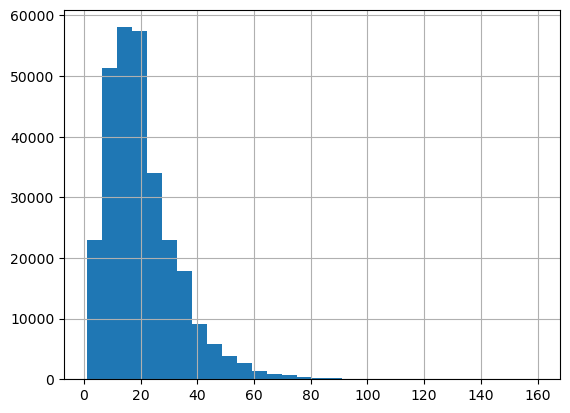

In [17]:
pd.Series(seq_len).hist(bins = 30)

In [18]:
### Group texts to decrease the number of sentences
manifesto['country_party_election_code'] = manifesto.country.str.cat(others=[manifesto.name, manifesto.election.astype(str), 
manifesto.code_extract.astype(str)], sep='_')


In [19]:
from utils.functions import group_texts
results = group_texts(manifesto, 'country_party_election_code','text', group_factor = 4)

Length of Spain_Convergència i Unió_2000_409 is: 47
Length of United Kingdom_Social Democratic and Labour Party_2019_604 is: 1
Length of Germany_Freie Demokratische Partei_1998_109 is: 5
Length of Spain_Ciudadanos - Partido de la Ciudadania_2015_409 is: 10
Length of Italy_Più Europa_2018_414 is: 9
Length of Germany_Partei des Demokratischen Sozialismus_1998_407 is: 4
Length of Italy_Partito della Rifondazione Comunista_2001_416 is: 142
Length of Spain_Partido Nacionalista Vasco/Euzko Alderdi Jeltzalea_2008_202 is: 47
Length of Spain_Podemos_2016_107 is: 26
Length of Spain_Coalición Canaria - Nueva Canarias_2000_403 is: 17
Length of Germany_Alternative für Deutschland_2017_506 is: 29
Length of Germany_Bündnis‘90/Die Grünen_2021_404 is: 1
Length of United States_Democratic Party_2012_705 is: 8
Length of Italy_Italia Europa Insieme_2018_503 is: 25
Length of United Kingdom_Plaid Cymru_2019_0 is: 1
Length of Spain_Partido Popular_1996_402 is: 137
Length of Germany_Sozialdemokratische Partei

In [20]:
manifesto_regrouped = pd.DataFrame(results)
manifesto_regrouped = manifesto_regrouped.explode('text').reset_index(drop=True)

In [21]:
df_cols = manifesto_regrouped['labels'].str.split('_', expand=True)
manifesto_regrouped = pd.concat([manifesto_regrouped, df_cols], axis=1)

In [22]:
manifesto_regrouped.columns = ['text', 'country_party_election_code', 'country','party', 'election', 'code']

In [23]:
manifesto_regrouped.groupby('code').count()

,text,country_party_election_code,country,party,election
code,,,,,
0,524,524,524,524,524
101,260,260,260,260,260
102,36,36,36,36,36
103,134,134,134,134,134
104,907,907,907,907,907
105,631,631,631,631,631
106,452,452,452,452,452
107,1961,1961,1961,1961,1961
108,1342,1342,1342,1342,1342


In [24]:
texts = manifesto_regrouped['text'].tolist()
from statistics import stdev, mean
## Before
seq_len = [len(i.split()) for i in texts]
seq_len_mean = mean(seq_len)
seq_len_std = stdev(seq_len)
seq_len_max = max(seq_len)
seq_len_min = min(seq_len)
print('Mean length (word) is: {}'.format(seq_len_mean))
print('Std length (word) is: {}'.format(seq_len_std))
print('Min length (word) is: {}'.format(seq_len_min))
print('Max length (word) is: {}'.format(seq_len_max))

Mean length (word) is: 78.24219131766975
Std length (word) is: 36.01295814143997
Min length (word) is: 1
Max length (word) is: 353


<AxesSubplot: >

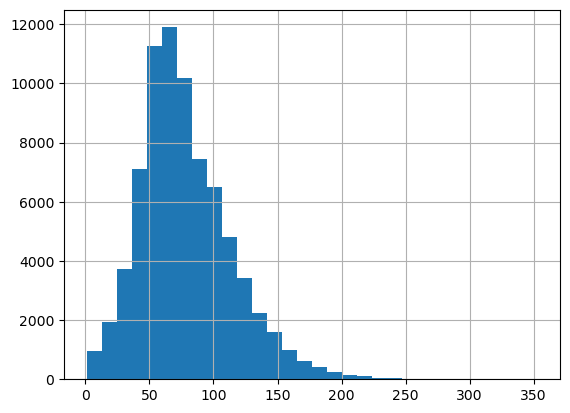

In [25]:
pd.Series(seq_len).hist(bins = 30)

### Domain adaptation with TSDAE

In [25]:
from sentence_transformers import SentenceTransformer, LoggingHandler
from sentence_transformers import models, util, datasets, evaluation, losses
from torch.utils.data import DataLoader

In [26]:
model_name = 'xlm-roberta-base'
word_embedding_model = models.Transformer(model_name)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'cls')
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
train_sentences = manifesto_regrouped['text'].tolist()
train_dataset = datasets.DenoisingAutoEncoderDataset(train_sentences)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
train_loss = losses.DenoisingAutoEncoderLoss(model, decoder_name_or_path=model_name, tie_encoder_decoder=True)

When tie_encoder_decoder=True, the decoder_name_or_path will be invalid.
Some weights of XLMRobertaForCausalLM were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['roberta.encoder.layer.8.crossattention.self.query.bias', 'roberta.encoder.layer.5.crossattention.self.key.bias', 'roberta.encoder.layer.11.crossattention.self.key.bias', 'roberta.encoder.layer.11.crossattention.output.dense.weight', 'roberta.encoder.layer.0.crossattention.output.dense.bias', 'roberta.encoder.layer.6.crossattention.self.key.weight', 'roberta.encoder.layer.4.crossattention.self.query.weight', 'roberta.encoder.layer.9.crossattention.self.query.weight', 'roberta.encoder.layer.11.crossattention.self.query.weight', 'roberta.encoder.layer.5.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.10.crossattention.self.value.weight', 'roberta.encoder.layer.5.crossattention.self.query.bias', 'roberta.encoder.layer.1.crossattention.output.dense.weight', 'roberta.encod

In [27]:
len(train_sentences)

75717

In [28]:
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=2,
    weight_decay=0,
    scheduler='constantlr',
    optimizer_params={'lr': 3e-5},
    show_progress_bar=True
)

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/9465 [00:00<?, ?it/s]

Iteration:   0%|          | 0/9465 [00:00<?, ?it/s]

In [ ]:
model.save('results/tsdae-model')

### Domain adaptation through fine-tuning: left - right - neutral

In [104]:
from utils.functions import lr_code 

In [105]:
manifesto_regrouped['lrn'] = manifesto_regrouped['code'].astype(int).apply(lr_code)

In [106]:
manifesto_regrouped.groupby('lrn').count()

,text,country_party_election_code,country,party,election,code
lrn,,,,,,
left,30032,30032,30032,30032,30032,30032
neutral,31186,31186,31186,31186,31186,31186
right,14499,14499,14499,14499,14499,14499


In [107]:
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at C:\Users\Hung/.cache\huggingface\hub\models--xlm-roberta-base\snapshots\77de1f7a7e5e737aead1cd880979d4f1b3af6668\config.json
Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

loading file senten

In [108]:
manifesto_reduced = manifesto_regrouped[['lrn','text']]

In [109]:
manifesto_dataset = Dataset.from_pandas(manifesto_reduced)
manifesto_dataset = manifesto_dataset.class_encode_column('lrn')
manifesto_dataset = manifesto_dataset.rename_column('lrn','labels')



Casting to class labels:   0%|          | 0/76 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/8 [00:00<?, ?ba/s]

In [110]:
train_test = manifesto_dataset.train_test_split(test_size=0.1, stratify_by_column='labels', seed=seed_val)
train_eval = train_test['train'].train_test_split(test_size=0.3, stratify_by_column='labels', seed=seed_val)

In [111]:
manifesto_datasets = DatasetDict({
    'train': train_eval['train'],
    'test': train_test['test'],
    'eval': train_eval['test']
})
manifesto_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 47701
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 7572
    })
    eval: Dataset({
        features: ['labels', 'text'],
        num_rows: 20444
    })
})

In [112]:
def tokenize_function(dataset):
    return tokenizer(dataset['text'], truncation=True)


In [113]:
tokenized_datasets = manifesto_datasets.map(tokenize_function, batched=True, remove_columns=['text'])

  0%|          | 0/48 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/21 [00:00<?, ?ba/s]

In [114]:
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

['labels', 'input_ids', 'attention_mask']

In [115]:
num_classes = len(set(manifesto_regrouped['lrn']))
model = XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_classes).to(device)


loading configuration file config.json from cache at C:\Users\Hung/.cache\huggingface\hub\models--xlm-roberta-base\snapshots\77de1f7a7e5e737aead1cd880979d4f1b3af6668\config.json
Model config XLMRobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002


In [116]:
## Declare important variables
batch_size = 32
num_epochs = 3
total_steps = len(tokenized_datasets['train'])//batch_size*num_epochs
logging_steps = total_steps//10
lr = 2e-5

In [117]:
training_args = TrainingArguments(
    output_dir="results/multilingual/manifesto_3cl",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=lr,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    logging_steps= logging_steps,
    num_train_epochs = num_epochs,
    save_strategy='epoch',
    load_best_model_at_end=True,
    optim='adamw_torch'
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [118]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average=None)
    matrix = confusion_matrix(labels, predictions)
    acc = matrix.diagonal()/matrix.sum(axis=1)
    return {
        'precision': precision.tolist(),
        'recall': recall.tolist(),
        'f1': f1.tolist(),
        'accuracy': acc.tolist()
    }
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["eval"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

Using cuda_amp half precision backend


In [119]:
trainer.train()

***** Running training *****
  Num examples = 47701
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 4473
  Number of trainable parameters = 278045955


  0%|          | 0/4473 [00:00<?, ?it/s]

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.8142, 'learning_rate': 1.8019226469930697e-05, 'epoch': 0.3}
{'loss': 0.5963, 'learning_rate': 1.602056785155377e-05, 'epoch': 0.6}
{'loss': 0.558, 'learning_rate': 1.402190923317684e-05, 'epoch': 0.9}


***** Running Evaluation *****
  Num examples = 20444
  Batch size = 32


  0%|          | 0/639 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.8410596026490066, 0.8474205583429821, 0.6730934018851756]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8300653594771242, 0.7823040380047506, 0.8025542784163474]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8355263157894738, 0.8135614154264188, 0.7321449376674822]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8300653594771242, 0.7823040380047506, 0.8025542784163474]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect s

{'eval_loss': 0.5049565434455872, 'eval_precision': [0.8410596026490066, 0.8474205583429821, 0.6730934018851756], 'eval_recall': [0.8300653594771242, 0.7823040380047506, 0.8025542784163474], 'eval_f1': [0.8355263157894738, 0.8135614154264188, 0.7321449376674822], 'eval_accuracy': [0.8300653594771242, 0.7823040380047506, 0.8025542784163474], 'eval_runtime': 46.3272, 'eval_samples_per_second': 441.296, 'eval_steps_per_second': 13.793, 'epoch': 1.0}


Model weights saved in results/multilingual/manifesto_3cl\checkpoint-1491\pytorch_model.bin
tokenizer config file saved in results/multilingual/manifesto_3cl\checkpoint-1491\tokenizer_config.json
Special tokens file saved in results/multilingual/manifesto_3cl\checkpoint-1491\special_tokens_map.json


{'loss': 0.466, 'learning_rate': 1.2032193158953724e-05, 'epoch': 1.2}
{'loss': 0.4284, 'learning_rate': 1.0033534540576794e-05, 'epoch': 1.5}
{'loss': 0.4092, 'learning_rate': 8.034875922199866e-06, 'epoch': 1.8}


***** Running Evaluation *****
  Num examples = 20444
  Batch size = 32


  0%|          | 0/639 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.8230279609002046, 0.8705577172503243, 0.7660060975609756]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8929584412381305, 0.7971496437054632, 0.7701149425287356]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8565682853256048, 0.832238065716057, 0.7680550248376004]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8929584412381305, 0.7971496437054632, 0.7701149425287356]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so

{'eval_loss': 0.4584812819957733, 'eval_precision': [0.8230279609002046, 0.8705577172503243, 0.7660060975609756], 'eval_recall': [0.8929584412381305, 0.7971496437054632, 0.7701149425287356], 'eval_f1': [0.8565682853256048, 0.832238065716057, 0.7680550248376004], 'eval_accuracy': [0.8929584412381305, 0.7971496437054632, 0.7701149425287356], 'eval_runtime': 44.3034, 'eval_samples_per_second': 461.454, 'eval_steps_per_second': 14.423, 'epoch': 2.0}


Model weights saved in results/multilingual/manifesto_3cl\checkpoint-2982\pytorch_model.bin
tokenizer config file saved in results/multilingual/manifesto_3cl\checkpoint-2982\tokenizer_config.json
Special tokens file saved in results/multilingual/manifesto_3cl\checkpoint-2982\special_tokens_map.json


{'loss': 0.3855, 'learning_rate': 6.036217303822938e-06, 'epoch': 2.1}
{'loss': 0.3218, 'learning_rate': 4.0375586854460095e-06, 'epoch': 2.4}
{'loss': 0.317, 'learning_rate': 2.0389000670690815e-06, 'epoch': 2.7}
{'loss': 0.306, 'learning_rate': 4.0241448692152927e-08, 'epoch': 3.0}


***** Running Evaluation *****
  Num examples = 20444
  Batch size = 32


  0%|          | 0/639 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.8626482213438735, 0.8445132848802573, 0.7734513274336283]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8612652608213096, 0.8418052256532067, 0.7813537675606641]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8619561863622338, 0.84315708083031, 0.7773824650571792]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8612652608213096, 0.8418052256532067, 0.7813537675606641]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so 

{'eval_loss': 0.45922592282295227, 'eval_precision': [0.8626482213438735, 0.8445132848802573, 0.7734513274336283], 'eval_recall': [0.8612652608213096, 0.8418052256532067, 0.7813537675606641], 'eval_f1': [0.8619561863622338, 0.84315708083031, 0.7773824650571792], 'eval_accuracy': [0.8612652608213096, 0.8418052256532067, 0.7813537675606641], 'eval_runtime': 42.7899, 'eval_samples_per_second': 477.776, 'eval_steps_per_second': 14.933, 'epoch': 3.0}


Model weights saved in results/multilingual/manifesto_3cl\checkpoint-4473\pytorch_model.bin
tokenizer config file saved in results/multilingual/manifesto_3cl\checkpoint-4473\tokenizer_config.json
Special tokens file saved in results/multilingual/manifesto_3cl\checkpoint-4473\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from results/multilingual/manifesto_3cl\checkpoint-2982 (score: 0.4584812819957733).


{'train_runtime': 2121.3208, 'train_samples_per_second': 67.459, 'train_steps_per_second': 2.109, 'train_loss': 0.4601726013889735, 'epoch': 3.0}


TrainOutput(global_step=4473, training_loss=0.4601726013889735, metrics={'train_runtime': 2121.3208, 'train_samples_per_second': 67.459, 'train_steps_per_second': 2.109, 'train_loss': 0.4601726013889735, 'epoch': 3.0})

In [120]:
res = trainer.evaluate(tokenized_datasets['test'])
print(sum(res['eval_f1'])/num_classes)

***** Running Evaluation *****
  Num examples = 7572
  Batch size = 32


  0%|          | 0/237 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.8160219311605239, 0.865797816132441, 0.7558620689655172]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8921078921078921, 0.7880731003526772, 0.7558620689655172]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8523703468024181, 0.8251090970124203, 0.7558620689655172]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8921078921078921, 0.7880731003526772, 0.7558620689655172]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so

0.8111138375934518


In [123]:
res_table = pd.DataFrame({'f1': np.round(res['eval_f1'],2), 'precision': np.round(res['eval_precision'],2), 
'recall': np.round(res['eval_recall'],2), 'accuracy': np.round(res['eval_accuracy'],2)})
res_table

,f1,precision,recall,accuracy
0,0.85,0.82,0.89,0.89
1,0.83,0.87,0.79,0.79
2,0.76,0.76,0.76,0.76


In [124]:
round(res_table.mean(axis=0),2)

f1           0.81
precision    0.82
recall       0.81
accuracy     0.81
dtype: float64

In [125]:
res_table.to_csv('results/tabs and figs/tsdae_ft_cls.csv', index=False)

### Domain adaptation through fine-tuning: sentiment

In [60]:
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)

In [52]:
manifesto_regrouped['sentiment'] = manifesto_regrouped['code'].astype(int).apply(sentiment_code)
manifesto_regrouped['topic'] = manifesto_regrouped['code'].astype(int).apply(topic_code)



In [53]:
manifesto_reduced = manifesto_regrouped[['sentiment','text']]

In [55]:
manifesto_dataset = Dataset.from_pandas(manifesto_reduced)
manifesto_dataset = manifesto_dataset.class_encode_column('sentiment')
manifesto_dataset = manifesto_dataset.rename_column('sentiment','labels')



Parameter 'function'=<function Dataset.class_encode_column.<locals>.cast_to_class_labels at 0x00000221644EA1F0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Casting to class labels:   0%|          | 0/76 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/8 [00:00<?, ?ba/s]

In [56]:
train_test = manifesto_dataset.train_test_split(test_size=0.1, stratify_by_column='labels', seed=seed_val)
train_eval = train_test['train'].train_test_split(test_size=0.3, stratify_by_column='labels', seed=seed_val)

In [57]:
manifesto_datasets = DatasetDict({
    'train': train_eval['train'],
    'test': train_test['test'],
    'eval': train_eval['test']
})
manifesto_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 47701
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 7572
    })
    eval: Dataset({
        features: ['labels', 'text'],
        num_rows: 20444
    })
})

In [58]:
def tokenize_function(dataset):
    return tokenizer(dataset['text'], truncation=True)


In [61]:
tokenized_datasets = manifesto_datasets.map(tokenize_function, batched=True, remove_columns=['text'])

  0%|          | 0/48 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/21 [00:00<?, ?ba/s]

In [62]:
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

['labels', 'input_ids', 'attention_mask']

In [63]:
num_classes = len(set(manifesto_regrouped['sentiment']))
model = XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_classes).to(device)


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

In [64]:
## Declare important variables
batch_size = 32
num_epochs = 3
total_steps = len(tokenized_datasets['train'])//batch_size*num_epochs
logging_steps = total_steps//10
lr = 2e-5

In [66]:
training_args = TrainingArguments(
    output_dir="results/multilingual/manifesto_3cl_sentiment",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=lr,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    logging_steps= logging_steps,
    num_train_epochs = num_epochs,
    save_strategy='epoch',
    load_best_model_at_end=True,
    optim='adamw_torch'
)

In [67]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average=None)
    matrix = confusion_matrix(labels, predictions)
    acc = matrix.diagonal()/matrix.sum(axis=1)
    return {
        'precision': precision.tolist(),
        'recall': recall.tolist(),
        'f1': f1.tolist(),
        'accuracy': acc.tolist()
    }
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["eval"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

Using cuda_amp half precision backend


In [68]:
trainer.train()

***** Running training *****
  Num examples = 47701
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 4473
  Number of trainable parameters = 278045955


  0%|          | 0/4473 [00:00<?, ?it/s]

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.8049, 'learning_rate': 1.8010283925776887e-05, 'epoch': 0.3}
{'loss': 0.6135, 'learning_rate': 1.602056785155377e-05, 'epoch': 0.6}
{'loss': 0.5634, 'learning_rate': 1.4035323049407556e-05, 'epoch': 0.9}


***** Running Evaluation *****
  Num examples = 20444
  Batch size = 32


  0%|          | 0/639 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.629863301787592, 0.7914996836110525, 0.8829695400172648]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6692737430167598, 0.8609613399105197, 0.7918602079186021]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6489707475622968, 0.8247705917907577, 0.8349367383826016]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6692737430167598, 0.8609613399105197, 0.7918602079186021]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so

{'eval_loss': 0.4952334463596344, 'eval_precision': [0.629863301787592, 0.7914996836110525, 0.8829695400172648], 'eval_recall': [0.6692737430167598, 0.8609613399105197, 0.7918602079186021], 'eval_f1': [0.6489707475622968, 0.8247705917907577, 0.8349367383826016], 'eval_accuracy': [0.6692737430167598, 0.8609613399105197, 0.7918602079186021], 'eval_runtime': 37.4651, 'eval_samples_per_second': 545.682, 'eval_steps_per_second': 17.056, 'epoch': 1.0}


Model weights saved in results/multilingual/manifesto_3cl_sentiment\checkpoint-1491\pytorch_model.bin
tokenizer config file saved in results/multilingual/manifesto_3cl_sentiment\checkpoint-1491\tokenizer_config.json
Special tokens file saved in results/multilingual/manifesto_3cl_sentiment\checkpoint-1491\special_tokens_map.json


{'loss': 0.4745, 'learning_rate': 1.203666443103063e-05, 'epoch': 1.2}
{'loss': 0.4389, 'learning_rate': 1.00380058126537e-05, 'epoch': 1.5}
{'loss': 0.4339, 'learning_rate': 8.039347194276772e-06, 'epoch': 1.8}


***** Running Evaluation *****
  Num examples = 20444
  Batch size = 32


  0%|          | 0/639 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.6829710144927537, 0.8467599670704458, 0.8513233852521512]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.702048417132216, 0.8259722381553287, 0.8644105286441053]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.692378328741965, 0.8362369337979095, 0.8578170443944465]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.702048417132216, 0.8259722381553287, 0.8644105286441053]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so w

{'eval_loss': 0.4489334225654602, 'eval_precision': [0.6829710144927537, 0.8467599670704458, 0.8513233852521512], 'eval_recall': [0.702048417132216, 0.8259722381553287, 0.8644105286441053], 'eval_f1': [0.692378328741965, 0.8362369337979095, 0.8578170443944465], 'eval_accuracy': [0.702048417132216, 0.8259722381553287, 0.8644105286441053], 'eval_runtime': 39.538, 'eval_samples_per_second': 517.073, 'eval_steps_per_second': 16.162, 'epoch': 2.0}


Model weights saved in results/multilingual/manifesto_3cl_sentiment\checkpoint-2982\pytorch_model.bin
tokenizer config file saved in results/multilingual/manifesto_3cl_sentiment\checkpoint-2982\tokenizer_config.json
Special tokens file saved in results/multilingual/manifesto_3cl_sentiment\checkpoint-2982\special_tokens_map.json


{'loss': 0.3924, 'learning_rate': 6.040688575899843e-06, 'epoch': 2.1}
{'loss': 0.3342, 'learning_rate': 4.0420299575229155e-06, 'epoch': 2.4}
{'loss': 0.3269, 'learning_rate': 2.043371339145987e-06, 'epoch': 2.7}
{'loss': 0.3216, 'learning_rate': 4.4712720769058795e-08, 'epoch': 3.0}


***** Running Evaluation *****
  Num examples = 20444
  Batch size = 32


  0%|          | 0/639 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.7338969404186796, 0.8377805068661383, 0.866377874041986]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6789571694599628, 0.8608466215441092, 0.8626410086264101]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.7053588701876572, 0.8491569537173249, 0.8645054031587698]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6789571694599628, 0.8608466215441092, 0.8626410086264101]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so

{'eval_loss': 0.4674117863178253, 'eval_precision': [0.7338969404186796, 0.8377805068661383, 0.866377874041986], 'eval_recall': [0.6789571694599628, 0.8608466215441092, 0.8626410086264101], 'eval_f1': [0.7053588701876572, 0.8491569537173249, 0.8645054031587698], 'eval_accuracy': [0.6789571694599628, 0.8608466215441092, 0.8626410086264101], 'eval_runtime': 38.3859, 'eval_samples_per_second': 532.591, 'eval_steps_per_second': 16.647, 'epoch': 3.0}


Model weights saved in results/multilingual/manifesto_3cl_sentiment\checkpoint-4473\pytorch_model.bin
tokenizer config file saved in results/multilingual/manifesto_3cl_sentiment\checkpoint-4473\tokenizer_config.json
Special tokens file saved in results/multilingual/manifesto_3cl_sentiment\checkpoint-4473\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from results/multilingual/manifesto_3cl_sentiment\checkpoint-2982 (score: 0.4489334225654602).


{'train_runtime': 1176.4768, 'train_samples_per_second': 121.637, 'train_steps_per_second': 3.802, 'train_loss': 0.47034727338440807, 'epoch': 3.0}


TrainOutput(global_step=4473, training_loss=0.47034727338440807, metrics={'train_runtime': 1176.4768, 'train_samples_per_second': 121.637, 'train_steps_per_second': 3.802, 'train_loss': 0.47034727338440807, 'epoch': 3.0})

In [69]:
res = trainer.evaluate(tokenized_datasets['test'])
print(sum(res['eval_f1'])/num_classes)

***** Running Evaluation *****
  Num examples = 7572
  Batch size = 32


  0%|          | 0/237 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.6972386587771203, 0.8565022421524664, 0.8483701979045402]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.7112676056338029, 0.8281201610405698, 0.8704090773365184]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.704183266932271, 0.8420721146276176, 0.8592483419307296]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.7112676056338029, 0.8281201610405698, 0.8704090773365184]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so

0.8018345744968727


In [72]:
res_table = pd.DataFrame({'f1': np.round(res['eval_f1'],2), 'precision': np.round(res['eval_precision'],2), 
'recall': np.round(res['eval_recall'],2), 'accuracy': np.round(res['eval_accuracy'],2)})
res_table

,f1,precision,recall,accuracy
0,0.70,0.70,0.71,0.71
1,0.84,0.86,0.83,0.83
2,0.86,0.85,0.87,0.87


In [73]:
round(res_table.mean(axis=0),2)

f1           0.8
precision    0.8
recall       0.8
accuracy     0.8
dtype: float64

In [74]:
res_table.to_csv('results/tabs and figs/ft_sentiment.csv', index=False)

### Example 1: Germany - CMP code

#### Preprocess data

In [26]:
from utils.functions import party_deu, cmp_scale, lr_code, cmp_scale_sentiment

In [27]:
manifesto_deu = manifesto[manifesto['country'] == 'Germany'].reset_index(drop=True)
manifesto_deu_rgr = manifesto_regrouped[manifesto_regrouped['country'] == 'Germany'].reset_index(drop=True)

In [28]:
manifesto_deu['party_agg'] = manifesto_deu['name'].apply(party_deu)
manifesto_deu_rgr['party_agg'] = manifesto_deu_rgr['party'].apply(party_deu)


In [29]:
manifesto_deu_rgr['lrn'] = manifesto_deu_rgr['code'].astype(int).apply(lr_code)
manifesto_deu['lrn'] = manifesto_deu['code_extract'].astype(int).apply(lr_code)

In [30]:
manifesto_deu = manifesto_deu[manifesto_deu.party_agg != 'NA'].reset_index(drop=True)
manifesto_deu_rgr = manifesto_deu_rgr[manifesto_deu_rgr.party_agg != 'NA'].reset_index(drop=True)

In [30]:
manifesto_deu_rgr.groupby('lrn').count()

,text,country_party_election_code,country,party,election,code,party_agg
lrn,,,,,,,
left,8104,8104,8104,8104,8104,8104,8104
neutral,7756,7756,7756,7756,7756,7756,7756
right,4533,4533,4533,4533,4533,4533,4533


In [39]:
absscale, relscale, logscale, name_ls = cmp_scale(manifesto_deu, group_vars=['party_agg','election'], sent_var='lrn')

('AfD', 2013)
('AfD', 2017)
('AfD', 2021)
('CDU/CSU', 1998)
('CDU/CSU', 2002)
('CDU/CSU', 2005)
('CDU/CSU', 2009)
('CDU/CSU', 2013)
('CDU/CSU', 2017)
('CDU/CSU', 2021)
('Die Grünen', 1998)
('Die Grünen', 2002)
('Die Grünen', 2005)
('Die Grünen', 2009)
('Die Grünen', 2013)
('Die Grünen', 2017)
('Die Grünen', 2021)
('FDP', 1998)
('FDP', 2002)
('FDP', 2005)
('FDP', 2009)
('FDP', 2013)
('FDP', 2017)
('FDP', 2021)
('PDS/Die Linke', 1998)
('PDS/Die Linke', 2002)
('PDS/Die Linke', 2005)
('PDS/Die Linke', 2009)
('PDS/Die Linke', 2013)
('PDS/Die Linke', 2017)
('PDS/Die Linke', 2021)
('SPD', 1998)
('SPD', 2002)
('SPD', 2005)
('SPD', 2009)
('SPD', 2013)
('SPD', 2017)
('SPD', 2021)


#### Scaling with Supervised UMAP

In [31]:
## Load pre-trained model 
transformer_model = 'results/multilingual/manifesto_3cl/checkpoint-2982'
word_embedding_model = models.Transformer(transformer_model)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'cls')
model = SentenceTransformer(modules=[word_embedding_model, pooling_model]).to(device)

Some weights of the model checkpoint at results/multilingual/manifesto_3cl/checkpoint-2982 were not used when initializing XLMRobertaModel: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at results/multilingual/manifesto_3cl/checkpoint-2982 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to b

In [82]:
from utils.functions import scale_topic

In [72]:
scaled_results = scale_topic(manifesto_deu_rgr, model, 'text', ['party_agg','election'] ,'lrn', batch_size=256, guidance_weight=0.5, use_pca=False, n_components=2, random_state=seed_val, metric='cosine')

The shape of this document embeddings is: (20393, 768)
UMAP(angular_rp_forest=True, metric='cosine', n_epochs=200, n_neighbors=500, random_state=1234, verbose=True)
Fri Sep 29 20:24:10 2023 Construct fuzzy simplicial set
Fri Sep 29 20:24:10 2023 Finding Nearest Neighbors
Fri Sep 29 20:24:10 2023 Building RP forest with 12 trees
Fri Sep 29 20:24:10 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Sep 29 20:24:37 2023 Finished Nearest Neighbor Search
Fri Sep 29 20:24:41 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Fri Sep 29 20:25:12 2023 Finished embedding


In [73]:
emb_mean_dict = {}
emb_se_dict = {}

for name, group in scaled_results[0].groupby(['party_agg','election']):
    idx = group.index
    embed = scaled_results[1][idx]
    embed_mean = embed.mean(axis=0)
    embed_se = embed.std(axis=0)/np.sqrt(len(group))
    name_full = '_'.join(name)
    emb_mean_dict.update({name_full: embed_mean})
    emb_se_dict.update({'_'.join([name_full, 'se']): embed_se})


In [74]:
umap_s_pos = np.stack(list(emb_mean_dict.values()))


In [75]:
umap_s_se = np.stack(list(emb_se_dict.values()))


In [78]:
np.corrcoef(logscale,umap_s_pos[:,1])

array([[ 1.        , -0.66846551],
       [-0.66846551,  1.        ]])

In [77]:
## Silhouette score
umap_s_silscore = silhouette_score(scaled_results[1], scaled_results[2].flatten())
umap_s_silscore

0.83986825

In [51]:
## Trustworthiness
umap_s_trust = trustworthiness(scaled_results[3], scaled_results[1], n_neighbors=5)
umap_s_trust

0.9768442833182033

[]

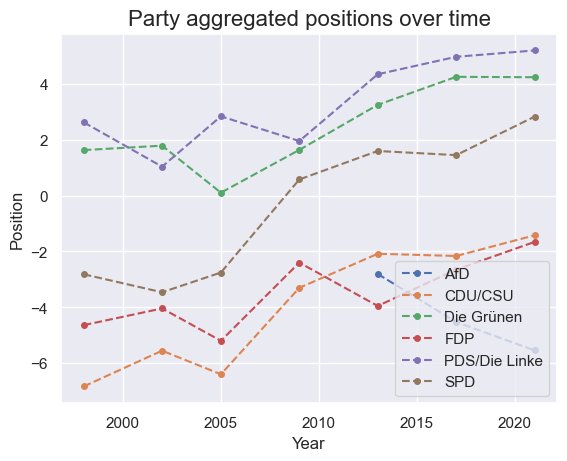

In [79]:
labels = ['_'.join([str(n) for n in name]) for name, group in manifesto_deu_rgr.groupby(['party_agg','election'])]
party = [lab.split('_')[0] for lab in labels]
year = [int(lab.split('_')[1]) for lab in labels]
#sentiment = [lab.split('_')[2] for lab in labels]


df = pd.DataFrame({'umap_dim1': umap_s_pos[:,0], 'umap_dim2': umap_s_pos[:,1], 'se_dim1': umap_s_se[:,0], 'se_dim2': umap_s_se[:,1],'party': party, 'election': year, 'lr_prop': relscale, 'lr_log': logscale, 'lr_abs': absscale}) 
sns.set_theme()
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in df.groupby('party'):
    ax.plot(group.election, group.umap_dim1, marker='o', linestyle='dashed', ms=4, label=name)
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Position')
ax.set_title('Party aggregated positions over time', fontdict={'fontsize':16})
plt.plot()


In [80]:
df.to_csv("results/arrays/tf_gen.csv", index=False)

### Example 2: Germany - by topics

In [31]:
from utils.functions import sentiment_code, topic_code

In [32]:
manifesto_deu_rgr['sentiment'] = manifesto_deu_rgr['code'].astype(int).apply(sentiment_code)
manifesto_deu_rgr['topic'] = manifesto_deu_rgr['code'].astype(int).apply(topic_code)

manifesto_deu['sentiment'] = manifesto_deu['code_extract'].astype(int).apply(sentiment_code)
manifesto_deu['topic'] = manifesto_deu['code_extract'].astype(int).apply(topic_code)

In [32]:
manifesto_deu_rgr.groupby(['topic','sentiment']).count()

text  country_party_election_code  country  \
topic                   sentiment                                               
constitutionalism       negative     13                           13       13   
                        positive     51                           51       51   
decentralisation        negative     77                           77       77   
                        positive    310                          310      310   
education               negative     14                           14       14   
                        positive    759                          759      759   
environment             negative    178                          178      178   
                        positive   1618                         1618     1618   
eu                      negative    123                          123      123   
                        positive    500                          500      500   
freemarket              negative   1412                         1412     1412   
                        positive    775                          775      775   
international relations negative     49                           49       49   
                        positive    752                          752      752   
irrelevant              unknown    9382                         9382     9382   
keynesian               negative    248                          248      248   
                        positive     66                           66       66   
labour groups           negative     37                           37       37   
                        positive   1012                         1012     1012   
military                negative    259                          259      259   
                        positive    189                          189      189   
multiculturalism        negative     92                           92       92   
                        positive    246                          246      246   
protectionism           negative     54                           54       54   
                        positive     35                           35       35   
traditionalism          negative    303                          303      303   
                        positive    488                          488      488   
welfare                 negative    119                          119      119   
                        positive   1232                         1232     1232   

                                   party  election  code  party_agg   lrn  
topic                   sentiment                                          
constitutionalism       negative      13        13    13         13    13  
                        positive      51        51    51         51    51  
decentralisation        negative      77        77    77         77    77  
                        positive     310       310   310        310   310  
education               negative      14        14    14         14    14  
                        positive     759       759   759        759   759  
environment             negative     178       178   178        178   178  
                        positive    1618      1618  1618       1618  1618  
eu                      negative     123       123   123        123   123  
                        positive     500       500   500        500   500  
freemarket              negative    1412      1412  1412       1412  1412  
                        positive     775       775   775        775   775  
international relations negative      49        49    49         49    49  
                        positive     752       752   752        752   752  
irrelevant              unknown     9382      9382  9382       9382  9382  
keynesian               negative     248       248   248        248   248  
                        positive      66        66    66         66    66  
labour groups           negative      37        37    37         37    37  
   

In [39]:
## Load pre-trained model 
transformer_model = 'results/multilingual/manifesto_3cl_sentiment/checkpoint-2982'
word_embedding_model = models.Transformer(transformer_model)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'cls')
model = SentenceTransformer(modules=[word_embedding_model, pooling_model]).to(device)

Some weights of the model checkpoint at results/multilingual/manifesto_3cl_sentiment/checkpoint-2982 were not used when initializing XLMRobertaModel: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at results/multilingual/manifesto_3cl_sentiment/checkpoint-2982 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a d

#### Traditionalism

In [63]:
manifesto_deu_rgr_td = manifesto_deu_rgr[manifesto_deu_rgr.topic == 'traditionalism'].reset_index(drop=True)
manifesto_deu_td = manifesto_deu[manifesto_deu.topic == 'traditionalism'].reset_index(drop=True)

In [86]:
len(manifesto_deu_rgr_td)

791

In [118]:
manifesto_deu_rgr_td.groupby('sentiment').count()

,text,country_party_election_code,country,party,election,code,party_agg,lrn,topic
sentiment,,,,,,,,,
negative,303,303,303,303,303,303,303,303,303
positive,488,488,488,488,488,488,488,488,488


In [88]:
absscale, relscale, logscale, name_ls = cmp_scale_sentiment(manifesto_deu_td, group_vars=['party_agg','election'], sent_var='sentiment')

('AfD', 2013)
('AfD', 2017)
('AfD', 2021)
('CDU/CSU', 1998)
('CDU/CSU', 2002)
('CDU/CSU', 2005)
('CDU/CSU', 2009)
('CDU/CSU', 2013)
('CDU/CSU', 2017)
('CDU/CSU', 2021)
('Die Grünen', 1998)
('Die Grünen', 2002)
('Die Grünen', 2005)
('Die Grünen', 2009)
('Die Grünen', 2013)
('Die Grünen', 2017)
('Die Grünen', 2021)
('FDP', 1998)
('FDP', 2002)
('FDP', 2005)
('FDP', 2009)
('FDP', 2013)
('FDP', 2017)
('FDP', 2021)
('PDS/Die Linke', 1998)
('PDS/Die Linke', 2002)
('PDS/Die Linke', 2005)
('PDS/Die Linke', 2009)
('PDS/Die Linke', 2013)
('PDS/Die Linke', 2017)
('PDS/Die Linke', 2021)
('SPD', 1998)
('SPD', 2002)
('SPD', 2005)
('SPD', 2009)
('SPD', 2013)
('SPD', 2017)
('SPD', 2021)


In [89]:
scaled_results = scale_topic(manifesto_deu_rgr_td, model, 'text', ['party_agg','election'] ,'sentiment', batch_size=256, guidance_weight=0.5, use_pca=False, n_components=2, random_state=seed_val, metric = 'cosine')

The shape of this document embeddings is: (791, 768)
UMAP(angular_rp_forest=True, metric='cosine', n_epochs=200, n_neighbors=250, random_state=1234, verbose=True)
Fri Sep 29 20:27:38 2023 Construct fuzzy simplicial set
Fri Sep 29 20:27:39 2023 Finding Nearest Neighbors
Fri Sep 29 20:27:40 2023 Finished Nearest Neighbor Search
Fri Sep 29 20:27:40 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Fri Sep 29 20:27:41 2023 Finished embedding


In [90]:
emb_mean_dict = {}
emb_se_dict = {}

for name, group in scaled_results[0].groupby(['party_agg','election']):
    idx = group.index
    embed = scaled_results[1][idx]
    embed_mean = embed.mean(axis=0)
    embed_se = embed.std(axis=0)/np.sqrt(len(group))
    name_full = '_'.join(name)
    emb_mean_dict.update({name_full: embed_mean})
    emb_se_dict.update({'_'.join([name_full, 'sd']): embed_se})


In [91]:
umap_td_pos = np.stack(list(emb_mean_dict.values()))


In [92]:
umap_td_se = np.stack(list(emb_se_dict.values()))


In [94]:
np.corrcoef(logscale,umap_td_pos[:,1])

array([[ 1.        , -0.92637059],
       [-0.92637059,  1.        ]])

[]

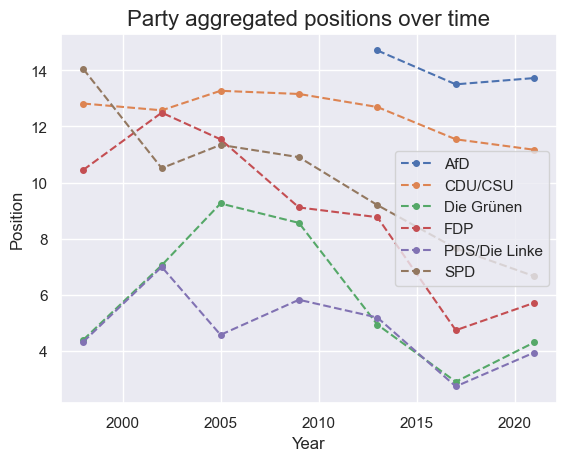

In [95]:
labels = ['_'.join([str(n) for n in name]) for name, group in manifesto_deu_td.groupby(['party_agg','election'])]
party = [lab.split('_')[0] for lab in labels]
year = [int(lab.split('_')[1]) for lab in labels]
#sentiment = [lab.split('_')[2] for lab in labels]


df = pd.DataFrame({'dim1': umap_td_pos[:,0], 'dim2': umap_td_pos[:,1], 'se_dim1': umap_td_se[:,0], 'se_dim2': umap_td_se[:,1], 'party': party, 'election': year, 'lr_prop': relscale, 'lr_log': logscale, 'lr_abs': absscale}) #,'dim2': score[:,1]
sns.set_theme()
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in df.groupby('party'):
    ax.plot(group.election, group.dim1, marker='o', linestyle='dashed', ms=4, label=name)
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Position')
ax.set_title('Party aggregated positions over time', fontdict={'fontsize':16})
plt.plot()


In [96]:
df.to_csv("results/arrays/tf_td.csv", index=False)

#### Welfare redistribution

In [35]:
manifesto_deu_rgr_wf = manifesto_deu_rgr[manifesto_deu_rgr.topic == 'welfare'].reset_index(drop=True)
manifesto_deu_wf = manifesto_deu[manifesto_deu.topic == 'welfare'].reset_index(drop=True)

In [70]:
len(manifesto_deu_rgr_wf)

1351

In [36]:
manifesto_deu_rgr_wf.groupby('sentiment').count()

,text,country_party_election_code,country,party,election,code,party_agg,lrn,topic
sentiment,,,,,,,,,
negative,119,119,119,119,119,119,119,119,119
positive,1232,1232,1232,1232,1232,1232,1232,1232,1232


In [98]:
absscale, relscale, logscale, name_ls = cmp_scale_sentiment(manifesto_deu_wf, group_vars=['party_agg','election'], sent_var='sentiment')

('AfD', 2013)
('AfD', 2017)
('AfD', 2021)
('CDU/CSU', 1998)
('CDU/CSU', 2002)
('CDU/CSU', 2005)
('CDU/CSU', 2009)
('CDU/CSU', 2013)
('CDU/CSU', 2017)
('CDU/CSU', 2021)
('Die Grünen', 1998)
('Die Grünen', 2002)
('Die Grünen', 2005)
('Die Grünen', 2009)
('Die Grünen', 2013)
('Die Grünen', 2017)
('Die Grünen', 2021)
('FDP', 1998)
('FDP', 2002)
('FDP', 2005)
('FDP', 2009)
('FDP', 2013)
('FDP', 2017)
('FDP', 2021)
('PDS/Die Linke', 1998)
('PDS/Die Linke', 2002)
('PDS/Die Linke', 2005)
('PDS/Die Linke', 2009)
('PDS/Die Linke', 2013)
('PDS/Die Linke', 2017)
('PDS/Die Linke', 2021)
('SPD', 1998)
('SPD', 2002)
('SPD', 2005)
('SPD', 2009)
('SPD', 2013)
('SPD', 2017)
('SPD', 2021)


In [99]:
scaled_results = scale_topic(manifesto_deu_rgr_wf, model, 'text', ['party_agg','election'] ,'sentiment', batch_size=256, guidance_weight=0.5, use_pca=False,n_components=2, random_state=seed_val, metric = 'cosine')

The shape of this document embeddings is: (1351, 768)
UMAP(angular_rp_forest=True, metric='cosine', n_epochs=200, n_neighbors=250, random_state=1234, verbose=True)
Fri Sep 29 20:28:12 2023 Construct fuzzy simplicial set
Fri Sep 29 20:28:14 2023 Finding Nearest Neighbors
Fri Sep 29 20:28:14 2023 Finished Nearest Neighbor Search
Fri Sep 29 20:28:14 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Fri Sep 29 20:28:16 2023 Finished embedding


In [100]:
emb_mean_dict = {}
emb_se_dict = {}

for name, group in scaled_results[0].groupby(['party_agg','election']):
    idx = group.index
    embed = scaled_results[1][idx]
    embed_mean = embed.mean(axis=0)
    embed_se = embed.std(axis=0)/np.sqrt(len(group))
    name_full = '_'.join(name)
    emb_mean_dict.update({name_full: embed_mean})
    emb_se_dict.update({'_'.join([name_full, 'sd']): embed_se})


In [101]:
umap_wf_pos = np.stack(list(emb_mean_dict.values()))


In [102]:
umap_wf_se = np.stack(list(emb_se_dict.values()))


In [104]:
np.corrcoef(logscale,umap_wf_pos[:,1])

array([[ 1.        , -0.34790059],
       [-0.34790059,  1.        ]])

[]

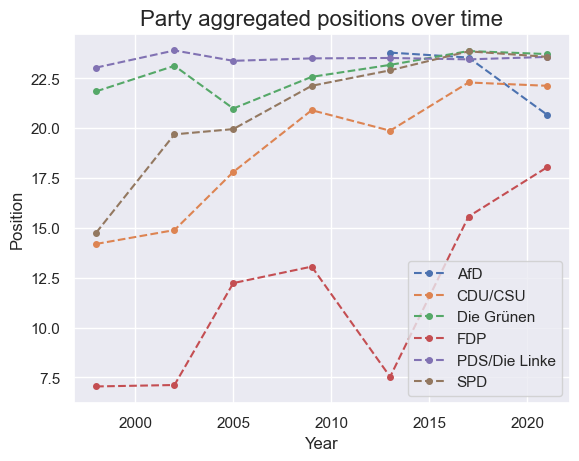

In [105]:
labels = ['_'.join([str(n) for n in name]) for name, group in manifesto_deu_wf.groupby(['party_agg','election'])]
party = [lab.split('_')[0] for lab in labels]
year = [int(lab.split('_')[1]) for lab in labels]
#sentiment = [lab.split('_')[2] for lab in labels]


df = pd.DataFrame({'dim1': umap_wf_pos[:,0], 'dim2': umap_wf_pos[:,1], 'se_dim1': umap_wf_se[:,0], 'se_dim2': umap_wf_se[:,1], 'party': party, 'election': year, 'lr_prop': relscale, 'lr_log': logscale, 'lr_abs': absscale}) #,'dim2': score[:,1]
sns.set_theme()
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in df.groupby('party'):
    ax.plot(group.election, group.dim1, marker='o', linestyle='dashed', ms=4, label=name)
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Position')
ax.set_title('Party aggregated positions over time', fontdict={'fontsize':16})
plt.plot()


In [106]:
df.to_csv("results/arrays/tf_wf.csv", index=False)

#### Free market

In [54]:
manifesto_deu_rgr_fm = manifesto_deu_rgr[manifesto_deu_rgr.topic == 'freemarket'].reset_index(drop=True)
manifesto_deu_fm = manifesto_deu[manifesto_deu.topic == 'freemarket'].reset_index(drop=True)

In [108]:
len(manifesto_deu_rgr_fm)

2187

In [109]:
manifesto_deu_rgr_fm.groupby('sentiment').count()

,text,country_party_election_code,country,party,election,code,party_agg,lrn,topic
sentiment,,,,,,,,,
negative,1412,1412,1412,1412,1412,1412,1412,1412,1412
positive,775,775,775,775,775,775,775,775,775


In [110]:
absscale, relscale, logscale, name_ls = cmp_scale_sentiment(manifesto_deu_fm, group_vars=['party_agg','election'], sent_var='sentiment')

('AfD', 2013)
('AfD', 2017)
('AfD', 2021)
('CDU/CSU', 1998)
('CDU/CSU', 2002)
('CDU/CSU', 2005)
('CDU/CSU', 2009)
('CDU/CSU', 2013)
('CDU/CSU', 2017)
('CDU/CSU', 2021)
('Die Grünen', 1998)
('Die Grünen', 2002)
('Die Grünen', 2005)
('Die Grünen', 2009)
('Die Grünen', 2013)
('Die Grünen', 2017)
('Die Grünen', 2021)
('FDP', 1998)
('FDP', 2002)
('FDP', 2005)
('FDP', 2009)
('FDP', 2013)
('FDP', 2017)
('FDP', 2021)
('PDS/Die Linke', 1998)
('PDS/Die Linke', 2002)
('PDS/Die Linke', 2005)
('PDS/Die Linke', 2009)
('PDS/Die Linke', 2013)
('PDS/Die Linke', 2017)
('PDS/Die Linke', 2021)
('SPD', 1998)
('SPD', 2002)
('SPD', 2005)
('SPD', 2009)
('SPD', 2013)
('SPD', 2017)
('SPD', 2021)


In [111]:
scaled_results = scale_topic(manifesto_deu_rgr_fm, model, 'text', ['party_agg','election'] ,'sentiment', batch_size=256, guidance_weight=0.5, use_pca=False, n_components=2, random_state=seed_val, metric = 'cosine')

The shape of this document embeddings is: (2187, 768)
UMAP(angular_rp_forest=True, metric='cosine', n_epochs=200, n_neighbors=250, random_state=1234, verbose=True)
Fri Sep 29 20:28:45 2023 Construct fuzzy simplicial set
Fri Sep 29 20:28:47 2023 Finding Nearest Neighbors
Fri Sep 29 20:28:48 2023 Finished Nearest Neighbor Search
Fri Sep 29 20:28:48 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Fri Sep 29 20:28:51 2023 Finished embedding


In [112]:
emb_mean_dict = {}
emb_se_dict = {}

for name, group in scaled_results[0].groupby(['party_agg','election']):
    idx = group.index
    embed = scaled_results[1][idx]
    embed_mean = embed.mean(axis=0)
    embed_se = embed.std(axis=0)/np.sqrt(len(group))
    name_full = '_'.join(name)
    emb_mean_dict.update({name_full: embed_mean})
    emb_se_dict.update({'_'.join([name_full, 'sd']): embed_se})


In [113]:
umap_fm_pos = np.stack(list(emb_mean_dict.values()))


In [114]:
umap_fm_se = np.stack(list(emb_se_dict.values()))


In [116]:
np.corrcoef(logscale,umap_wf_pos[:,1])

array([[1.        , 0.34256509],
       [0.34256509, 1.        ]])

[]

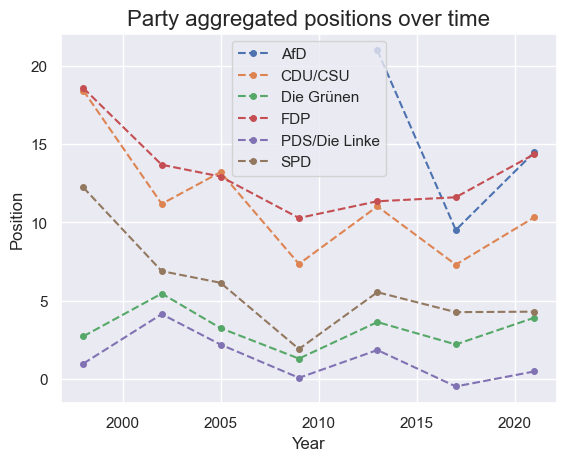

In [117]:
labels = ['_'.join([str(n) for n in name]) for name, group in manifesto_deu_fm.groupby(['party_agg','election'])]
party = [lab.split('_')[0] for lab in labels]
year = [int(lab.split('_')[1]) for lab in labels]
#sentiment = [lab.split('_')[2] for lab in labels]


df = pd.DataFrame({'dim1': umap_fm_pos[:,0], 'dim2': umap_fm_pos[:,1], 'se_dim1': umap_fm_se[:,0], 'se_dim2': umap_fm_se[:,1], 'party': party, 'election': year, 'lr_prop': relscale, 'lr_log': logscale, 'lr_abs': absscale}) #,'dim2': score[:,1]
sns.set_theme()
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in df.groupby('party'):
    ax.plot(group.election, group.dim1, marker='o', linestyle='dashed', ms=4, label=name)
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Position')
ax.set_title('Party aggregated positions over time', fontdict={'fontsize':16})
plt.plot()


In [118]:
df.to_csv("results/arrays/tf_fm.csv", index=False)

#### Environment

In [33]:
manifesto_deu_rgr_env = manifesto_deu_rgr[manifesto_deu_rgr.topic == 'environment'].reset_index(drop=True)
manifesto_deu_env = manifesto_deu[manifesto_deu.topic == 'environment'].reset_index(drop=True)

In [120]:
len(manifesto_deu_rgr_env)

1796

In [41]:
manifesto_deu_rgr_env.groupby('sentiment').count()

,text,country_party_election_code,country,party,election,code,party_agg,lrn,topic
sentiment,,,,,,,,,
negative,178,178,178,178,178,178,178,178,178
positive,1618,1618,1618,1618,1618,1618,1618,1618,1618


In [122]:
absscale, relscale, logscale, name_ls = cmp_scale_sentiment(manifesto_deu_env, group_vars=['party_agg','election'], sent_var='sentiment')

('AfD', 2013)
('AfD', 2017)
('AfD', 2021)
('CDU/CSU', 1998)
('CDU/CSU', 2002)
('CDU/CSU', 2005)
('CDU/CSU', 2009)
('CDU/CSU', 2013)
('CDU/CSU', 2017)
('CDU/CSU', 2021)
('Die Grünen', 1998)
('Die Grünen', 2002)
('Die Grünen', 2005)
('Die Grünen', 2009)
('Die Grünen', 2013)
('Die Grünen', 2017)
('Die Grünen', 2021)
('FDP', 1998)
('FDP', 2002)
('FDP', 2005)
('FDP', 2009)
('FDP', 2013)
('FDP', 2017)
('FDP', 2021)
('PDS/Die Linke', 1998)
('PDS/Die Linke', 2002)
('PDS/Die Linke', 2005)
('PDS/Die Linke', 2009)
('PDS/Die Linke', 2013)
('PDS/Die Linke', 2017)
('PDS/Die Linke', 2021)
('SPD', 1998)
('SPD', 2002)
('SPD', 2005)
('SPD', 2009)
('SPD', 2013)
('SPD', 2017)
('SPD', 2021)


In [123]:
scaled_results = scale_topic(manifesto_deu_rgr_env, model, 'text', ['party_agg','election'] ,'sentiment', batch_size=256, guidance_weight=0.5, use_pca=False, n_components=2, random_state=seed_val, metric = 'cosine')

The shape of this document embeddings is: (1796, 768)
UMAP(angular_rp_forest=True, metric='cosine', n_epochs=200, n_neighbors=250, random_state=1234, verbose=True)
Fri Sep 29 20:29:24 2023 Construct fuzzy simplicial set
Fri Sep 29 20:29:26 2023 Finding Nearest Neighbors
Fri Sep 29 20:29:26 2023 Finished Nearest Neighbor Search
Fri Sep 29 20:29:26 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Fri Sep 29 20:29:29 2023 Finished embedding


In [124]:
emb_mean_dict = {}
emb_se_dict = {}

for name, group in scaled_results[0].groupby(['party_agg','election']):
    idx = group.index
    embed = scaled_results[1][idx]
    embed_mean = embed.mean(axis=0)
    embed_se = embed.std(axis=0)/np.sqrt(len(group))
    name_full = '_'.join(name)
    emb_mean_dict.update({name_full: embed_mean})
    emb_se_dict.update({'_'.join([name_full, 'sd']): embed_se})


In [125]:
umap_env_pos = np.stack(list(emb_mean_dict.values()))


In [126]:
umap_env_se = np.stack(list(emb_se_dict.values()))


In [128]:
np.corrcoef(logscale,umap_wf_pos[:,1])

array([[ 1.        , -0.23733887],
       [-0.23733887,  1.        ]])

[]

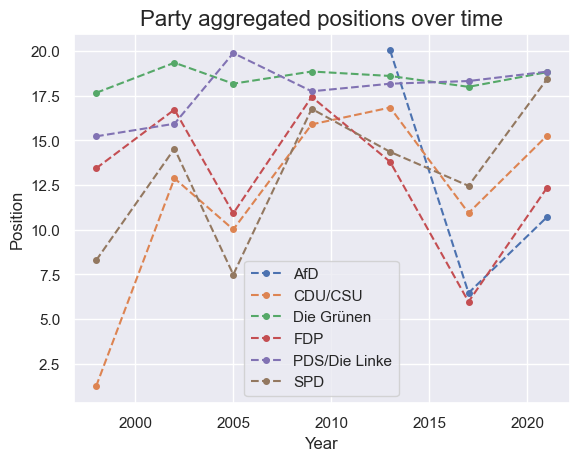

In [129]:
labels = ['_'.join([str(n) for n in name]) for name, group in manifesto_deu_fm.groupby(['party_agg','election'])]
party = [lab.split('_')[0] for lab in labels]
year = [int(lab.split('_')[1]) for lab in labels]
#sentiment = [lab.split('_')[2] for lab in labels]


df = pd.DataFrame({'dim1': umap_env_pos[:,0], 'dim2': umap_env_pos[:,1], 'se_dim1': umap_env_se[:,0], 'se_dim2': umap_env_se[:,1], 'party': party, 'election': year, 'lr_prop': relscale, 'lr_log': logscale, 'lr_abs': absscale}) #,'dim2': score[:,1]
sns.set_theme()
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in df.groupby('party'):
    ax.plot(group.election, group.dim1, marker='o', linestyle='dashed', ms=4, label=name)
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Position')
ax.set_title('Party aggregated positions over time', fontdict={'fontsize':16})
plt.plot()


In [130]:
df.to_csv("results/arrays/tf_env.csv", index=False)

#### BERTopic - Environment

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

In [35]:
## Load pre-trained model 
transformer_model = 'results/multilingual/manifesto_3cl_sentiment/checkpoint-2982'
word_embedding_model = models.Transformer(transformer_model)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'cls')
sentence_model  = SentenceTransformer(modules=[word_embedding_model, pooling_model]).to(device)
umap_model = umap.UMAP(
                n_components=2,
                n_neighbors=250,
                n_epochs=200,
                low_memory=True,
                verbose=True,
                random_state=seed_val
            )
vectorizer_model = CountVectorizer(stop_words=stopwords.words('german'))


Some weights of the model checkpoint at results/multilingual/manifesto_3cl_sentiment/checkpoint-2982 were not used when initializing XLMRobertaModel: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at results/multilingual/manifesto_3cl_sentiment/checkpoint-2982 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a d

In [36]:
topic_model = BERTopic(embedding_model=sentence_model, umap_model = umap_model, 
vectorizer_model=vectorizer_model, top_n_words = 10, nr_topics=5)


In [37]:
texts_env = manifesto_deu_rgr_env['text'].tolist()

In [38]:
topics, probs = topic_model.fit_transform(texts_env)

UMAP(n_epochs=200, n_neighbors=250, random_state=1234, verbose=True)
Sat Sep 30 00:42:07 2023 Construct fuzzy simplicial set
Sat Sep 30 00:42:08 2023 Finding Nearest Neighbors
Sat Sep 30 00:42:11 2023 Finished Nearest Neighbor Search
Sat Sep 30 00:42:13 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Sat Sep 30 00:42:16 2023 Finished embedding


In [39]:
fig = topic_model.visualize_barchart(n_words=10, width=350)
fig

In [55]:
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 600,
    'width': 1800,
    'scale': 2.5 # Multiply title/legend/axis/canvas sizes by this factor
  }
}


In [56]:
fig.write_html('results/tabs and figs/figure 4.html', config=config)

In [65]:
env_subtopics = pd.concat([topic_model.get_document_info(texts_env), manifesto_deu_rgr_env], axis=1)

In [66]:
env_subtopics.head()

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document,text,country_party_election_code,country,party,election,code,party_agg,lrn,sentiment,topic
0,"Ob wir ein nachhaltiges Deutschland schaffen, ...",0,0_müssen_umwelt_mehr_deutschland,"[müssen, umwelt, mehr, deutschland, ökologisch...","[Ziel muss es sein, dass Europa seinen Ausstoß...",müssen - umwelt - mehr - deutschland - ökologi...,1.000000,False,"Ob wir ein nachhaltiges Deutschland schaffen, ...",Germany_Sozialdemokratische Partei Deutschland...,Germany,Sozialdemokratische Partei Deutschlands,2009,416,SPD,left,positive,environment
1,Mehr German Mut für mehr Klimaschutz Deshalb m...,0,0_müssen_umwelt_mehr_deutschland,"[müssen, umwelt, mehr, deutschland, ökologisch...","[Ziel muss es sein, dass Europa seinen Ausstoß...",müssen - umwelt - mehr - deutschland - ökologi...,0.765311,False,Mehr German Mut für mehr Klimaschutz Deshalb m...,Germany_Freie Demokratische Partei_2021_501,Germany,Freie Demokratische Partei,2021,501,FDP,left,positive,environment
2,Wir Freie Demokraten werden uns bei der ökolog...,0,0_müssen_umwelt_mehr_deutschland,"[müssen, umwelt, mehr, deutschland, ökologisch...","[Ziel muss es sein, dass Europa seinen Ausstoß...",müssen - umwelt - mehr - deutschland - ökologi...,1.000000,False,Wir Freie Demokraten werden uns bei der ökolog...,Germany_Freie Demokratische Partei_2021_501,Germany,Freie Demokratische Partei,2021,501,FDP,left,positive,environment
3,und einen umweltfreundlichen Verkehrsfluss vor...,0,0_müssen_umwelt_mehr_deutschland,"[müssen, umwelt, mehr, deutschland, ökologisch...","[Ziel muss es sein, dass Europa seinen Ausstoß...",müssen - umwelt - mehr - deutschland - ökologi...,0.921951,False,und einen umweltfreundlichen Verkehrsfluss vor...,Germany_Freie Demokratische Partei_2021_501,Germany,Freie Demokratische Partei,2021,501,FDP,left,positive,environment
4,Der Emissionshandel garantiert eine Deckelung ...,0,0_müssen_umwelt_mehr_deutschland,"[müssen, umwelt, mehr, deutschland, ökologisch...","[Ziel muss es sein, dass Europa seinen Ausstoß...",müssen - umwelt - mehr - deutschland - ökologi...,0.992791,False,Der Emissionshandel garantiert eine Deckelung ...,Germany_Freie Demokratische Partei_2021_501,Germany,Freie Demokratische Partei,2021,501,FDP,left,positive,environment


In [76]:
env_subtopics_1 = env_subtopics[env_subtopics.Topic == 0].reset_index(drop=True)
env_subtopics_2 = env_subtopics[env_subtopics.Topic == 1].reset_index(drop=True)


In [77]:
env_subtopics_1.groupby(['party_agg','sentiment']).count()

,,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document,text,country_party_election_code,country,party,election,code,lrn,topic
party_agg,sentiment,,,,,,,,,,,,,,,,
AfD,positive,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11
CDU/CSU,positive,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120
Die Grünen,positive,462,462,462,462,462,462,462,462,462,462,462,462,462,462,462,462
FDP,positive,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100
PDS/Die Linke,positive,164,164,164,164,164,164,164,164,164,164,164,164,164,164,164,164
SPD,positive,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120


In [78]:
env_subtopics_2.groupby(['party_agg','code', 'sentiment']).count()

Document  Topic  Name  Representation  \
party_agg     code sentiment                                          
AfD           410  negative          6      6     6               6   
CDU/CSU       410  negative         45     45    45              45   
              416  positive          7      7     7               7   
              501  positive          6      6     6               6   
Die Grünen    410  negative         13     13    13              13   
              416  positive         61     61    61              61   
              501  positive         38     38    38              38   
FDP           410  negative         46     46    46              46   
              416  positive          4      4     4               4   
              501  positive         10     10    10              10   
PDS/Die Linke 410  negative          5      5     5               5   
              416  positive         32     32    32              32   
              501  positive         14     14    14              14   
SPD           410  negative         43     43    43              43   
              416  positive          7      7     7               7   
              501  positive          7      7     7               7   

                              Representative_Docs  Top_n_words  Probability  \
party_agg     code sentiment                                                  
AfD           410  negative                     6            6            6   
CDU/CSU       410  negative                    45           45           45   
              416  positive                     7            7            7   
              501  positive                     6            6            6   
Die Grünen    410  negative                    13           13           13   
              416  positive                    61           61           61   
              501  positive                    38           38           38   
FDP           410  negative                    46           46           46   
              416  positive                     4            4            4   
              501  positive                    10           10           10   
PDS/Die Linke 410  negative                     5            5            5   
              416  positive                    32           32           32   
              501  positive                    14           14           14   
SPD           410  negative                    43           43           43   
              416  positive                     7            7            7   
              501  positive                     7            7            7   

                              Representative_document  text  \
party_agg     code sentiment                                  
AfD           410  negative                         6     6   
CDU/CSU       410  negative                        45    45   
              416  positive                         7     7   
              501  positive                         6     6   
Die Grünen    410  negative                        13    13   
              416  positive                        61    61   
              501  positive                        38    38   
FDP           410  negative                        46    46   
              416  positive                         4     4   
              501  positive                        10    10   
PDS/Die Linke 410  negative                         5     5   
              416  positive                        32    32   
              501  positive                        14    14   
SPD           410  negative                        43    43   
              416  positive                         7     7   
              501  positive                         7     7   

                              country_party_election_code  country  party  \
party_agg     code sentiment                                                
AfD           410  negative            

In [ ]:
env_subtopics_1.to_csv('data/py_outputs/env_sub1.csv')
env_subtopics_2.to_csv('data/py_outputs/env_sub2.csv')

In [79]:
## Load pre-trained model 
transformer_model = 'results/multilingual/manifesto_3cl_sentiment/checkpoint-2982'
word_embedding_model = models.Transformer(transformer_model)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'cls')
model = SentenceTransformer(modules=[word_embedding_model, pooling_model]).to(device)

Some weights of the model checkpoint at results/multilingual/manifesto_3cl_sentiment/checkpoint-2982 were not used when initializing XLMRobertaModel: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at results/multilingual/manifesto_3cl_sentiment/checkpoint-2982 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a d

In [80]:
absscale, relscale, logscale, name_ls = cmp_scale_sentiment(env_subtopics_1, group_vars=['party_agg','election'], sent_var='sentiment')

('AfD', '2013')
('AfD', '2017')
('AfD', '2021')
('CDU/CSU', '1998')
('CDU/CSU', '2002')
('CDU/CSU', '2005')
('CDU/CSU', '2009')
('CDU/CSU', '2013')
('CDU/CSU', '2017')
('CDU/CSU', '2021')
('Die Grünen', '1998')
('Die Grünen', '2002')
('Die Grünen', '2005')
('Die Grünen', '2009')
('Die Grünen', '2013')
('Die Grünen', '2017')
('Die Grünen', '2021')
('FDP', '1998')
('FDP', '2002')
('FDP', '2005')
('FDP', '2009')
('FDP', '2013')
('FDP', '2017')
('FDP', '2021')
('PDS/Die Linke', '1998')
('PDS/Die Linke', '2002')
('PDS/Die Linke', '2005')
('PDS/Die Linke', '2009')
('PDS/Die Linke', '2013')
('PDS/Die Linke', '2017')
('PDS/Die Linke', '2021')
('SPD', '1998')
('SPD', '2002')
('SPD', '2005')
('SPD', '2009')
('SPD', '2013')
('SPD', '2017')
('SPD', '2021')


In [83]:
scaled_results = scale_topic(env_subtopics_1, model, 'text', ['party_agg','election'] ,'sentiment', batch_size=256, guidance_weight=0.5, use_pca=False,n_components=2, random_state=seed_val, metric = 'cosine')

The shape of this document embeddings is: (977, 768)
UMAP(angular_rp_forest=True, metric='cosine', n_epochs=200, n_neighbors=250, random_state=1234, verbose=True)
Sat Sep 30 00:23:45 2023 Construct fuzzy simplicial set
Sat Sep 30 00:23:46 2023 Finding Nearest Neighbors
Sat Sep 30 00:23:46 2023 Finished Nearest Neighbor Search
Sat Sep 30 00:23:47 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Sat Sep 30 00:23:49 2023 Finished embedding


In [84]:
emb_mean_dict = {}
emb_se_dict = {}

for name, group in scaled_results[0].groupby(['party_agg','election']):
    idx = group.index
    embed = scaled_results[1][idx]
    embed_mean = embed.mean(axis=0)
    embed_se = embed.std(axis=0)/np.sqrt(len(group))
    name_full = '_'.join(name)
    emb_mean_dict.update({name_full: embed_mean})
    emb_se_dict.update({'_'.join([name_full, 'sd']): embed_se})


In [85]:
umap_env1_pos = np.stack(list(emb_mean_dict.values()))


In [86]:
umap_env1_se = np.stack(list(emb_se_dict.values()))


In [87]:
np.corrcoef(logscale,umap_env1_pos[:,0])

array([[1.        , 0.04704417],
       [0.04704417, 1.        ]])

[]

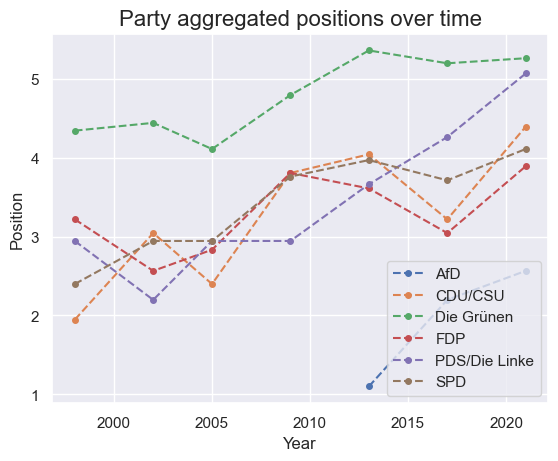

In [91]:
labels = ['_'.join([str(n) for n in name]) for name, group in env_subtopics_1.groupby(['party_agg','election'])]
party = [lab.split('_')[0] for lab in labels]
year = [int(lab.split('_')[1]) for lab in labels]
#sentiment = [lab.split('_')[2] for lab in labels]


df = pd.DataFrame({'dim1': umap_env1_pos[:,0], 'dim2': umap_env1_pos[:,1], 'se_dim1': umap_env1_se[:,0], 'se_dim2': umap_env1_se[:,1], 'party': party, 'election': year, 'lr_prop': relscale, 'lr_log': logscale, 'lr_abs': absscale}) #,'dim2': score[:,1]
sns.set_theme()
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in df.groupby('party'):
    ax.plot(group.election, group.lr_log, marker='o', linestyle='dashed', ms=4, label=name)
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Position')
ax.set_title('Party aggregated positions over time', fontdict={'fontsize':16})
plt.plot()


In [92]:
df.to_csv("results/arrays/tf_env1.csv", index=False)

In [93]:
absscale, relscale, logscale, name_ls = cmp_scale_sentiment(env_subtopics_2, group_vars=['party_agg','election'], sent_var='sentiment')

('AfD', '2017')
('AfD', '2021')
('CDU/CSU', '1998')
('CDU/CSU', '2002')
('CDU/CSU', '2005')
('CDU/CSU', '2009')
('CDU/CSU', '2013')
('CDU/CSU', '2017')
('CDU/CSU', '2021')
('Die Grünen', '1998')
('Die Grünen', '2002')
('Die Grünen', '2005')
('Die Grünen', '2009')
('Die Grünen', '2013')
('Die Grünen', '2017')
('Die Grünen', '2021')
('FDP', '1998')
('FDP', '2002')
('FDP', '2005')
('FDP', '2009')
('FDP', '2013')
('FDP', '2017')
('FDP', '2021')
('PDS/Die Linke', '1998')
('PDS/Die Linke', '2002')
('PDS/Die Linke', '2009')
('PDS/Die Linke', '2013')
('PDS/Die Linke', '2017')
('PDS/Die Linke', '2021')
('SPD', '1998')
('SPD', '2002')
('SPD', '2005')
('SPD', '2009')
('SPD', '2013')
('SPD', '2017')
('SPD', '2021')


In [94]:
scaled_results = scale_topic(env_subtopics_2, model, 'text', ['party_agg','election'] ,'sentiment', batch_size=256, guidance_weight=0.5, use_pca=False,n_components=2, random_state=seed_val, metric = 'cosine')

The shape of this document embeddings is: (344, 768)
UMAP(angular_rp_forest=True, metric='cosine', n_epochs=200, n_neighbors=250, random_state=1234, verbose=True)
Sat Sep 30 00:24:24 2023 Construct fuzzy simplicial set
Sat Sep 30 00:24:24 2023 Finding Nearest Neighbors
Sat Sep 30 00:24:24 2023 Finished Nearest Neighbor Search
Sat Sep 30 00:24:24 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Sat Sep 30 00:24:25 2023 Finished embedding


In [95]:
emb_mean_dict = {}
emb_se_dict = {}

for name, group in scaled_results[0].groupby(['party_agg','election']):
    idx = group.index
    embed = scaled_results[1][idx]
    embed_mean = embed.mean(axis=0)
    embed_se = embed.std(axis=0)/np.sqrt(len(group))
    name_full = '_'.join(name)
    emb_mean_dict.update({name_full: embed_mean})
    emb_se_dict.update({'_'.join([name_full, 'sd']): embed_se})


In [96]:
umap_env2_pos = np.stack(list(emb_mean_dict.values()))


In [97]:
umap_env2_se = np.stack(list(emb_se_dict.values()))


In [98]:
np.corrcoef(logscale,umap_env2_pos[:,1])

array([[ 1.        , -0.97425174],
       [-0.97425174,  1.        ]])

[]

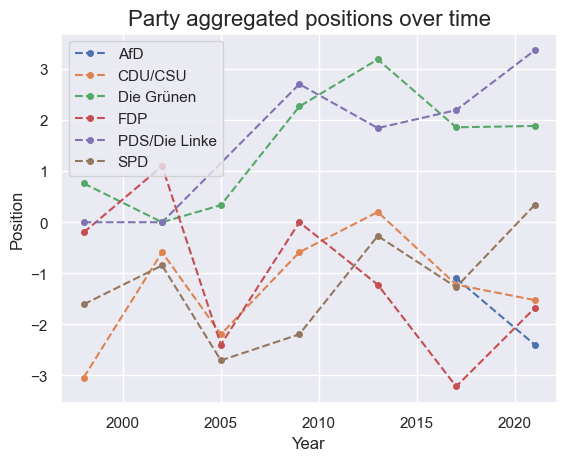

In [101]:
labels = ['_'.join([str(n) for n in name]) for name, group in env_subtopics_2.groupby(['party_agg','election'])]
party = [lab.split('_')[0] for lab in labels]
year = [int(lab.split('_')[1]) for lab in labels]
#sentiment = [lab.split('_')[2] for lab in labels]


df = pd.DataFrame({'dim1': umap_env2_pos[:,0], 'dim2': umap_env2_pos[:,1], 'se_dim1': umap_env2_se[:,0], 'se_dim2': umap_env2_se[:,1], 'party': party, 'election': year, 'lr_prop': relscale, 'lr_log': logscale, 'lr_abs': absscale}) #,'dim2': score[:,1]
sns.set_theme()
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in df.groupby('party'):
    ax.plot(group.election, group.lr_log, marker='o', linestyle='dashed', ms=4, label=name)
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Position')
ax.set_title('Party aggregated positions over time', fontdict={'fontsize':16})
plt.plot()


In [100]:
df.to_csv("results/arrays/tf_env2.csv", index=False)

# Validity checks

## Validation: Comparing embeddings quality through classification performances

#### Bags-of-words with TF-IDF

In [138]:
## Preprocessing for bag-of-words and word2vec models is a little different (pre-trained)
## Tokenizer - use gensim's tokenizer 
def clean_text(text, stopwords):
    custom_filters = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_numeric, strip_multiple_whitespaces]
    text = preprocess_string(text, custom_filters)
    tokens = [w for w in text if w not in stopwords]
    return ' '.join(tokens)


In [80]:
set(manifesto_regrouped['country'])

{'France', 'Germany', 'Italy', 'Spain', 'United Kingdom'}

In [ ]:
outputs = []
for idx, text in enumerate(manifesto_regrouped['text']):
    if idx % 10000 ==0:
        print(f'Cleaning the {idx}th sentence')
    country = manifesto_regrouped.loc[idx,'country'].lower()
    if country == 'france':
        outputs.append(clean_text(text, stopwords.words('french')))
    elif country == 'germany':
        outputs.append(clean_text(text, stopwords.words('german')))
    elif country == 'italy':
        outputs.append(clean_text(text, stopwords.words('italian')))
    elif country == 'spain':
        outputs.append(clean_text(text, stopwords.words('spanish')))
    else:
        outputs.append(clean_text(text, stopwords.words('english')))

In [82]:
manifesto_regrouped['text_cleaned'] = outputs

In [83]:
## Before
manifesto_regrouped.loc[0,'text']

"The problem: This country's education has been underfunded and undermined by repeated shifts in policy. Standards are too low, especially in core skills such as reading and maths. Britain is too low in the world league tables."

In [84]:
## After
outputs[0]

'problem country education underfunded undermined repeated shifts policy standards low especially core skills reading maths britain low world league tables'

In [86]:
df_train, df_test = train_test_split(manifesto_regrouped, test_size=0.15, stratify = manifesto_regrouped['sentiment'],random_state=seed_val)
df_train, df_eval = train_test_split(df_train, test_size=0.3, stratify = df_train['sentiment'], random_state=seed_val)
enc = OrdinalEncoder()

df_train['labels'] = enc.fit_transform(np.array(df_train['sentiment'].tolist()).reshape(-1,1))
df_test['labels'] = enc.fit_transform(np.array(df_test['sentiment'].tolist()).reshape(-1,1))
df_eval['labels'] = enc.fit_transform(np.array(df_eval['sentiment'].tolist()).reshape(-1,1))

df_train = df_train.reset_index(drop=True)
df_eval = df_eval.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)



In [87]:
y_train = np.array(df_train['labels'])
y_eval = np.array(df_eval['labels'])
y_test = np.array(df_test['labels'])

In [88]:
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

In [95]:
corp_train = df_train['text_cleaned'].tolist()
vectorizer.fit(corp_train)
X_train = vectorizer.transform(corp_train)
dic_vocabulary = vectorizer.vocabulary_

In [96]:
classifier = naive_bayes.MultinomialNB()

In [97]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = df_test["text_cleaned"].tolist()
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

In [98]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, predicted, average=None)
matrix = confusion_matrix(y_test, predicted)
accuracy = matrix.diagonal()/matrix.sum(axis=1)

In [99]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.71,0.69,0.73,0.73
1,0.67,0.67,0.68,0.68
2,0.50,0.56,0.45,0.45


In [100]:
round(res_table.mean(axis=0),2)

f1           0.63
precision    0.64
recall       0.62
accuracy     0.62
dtype: float64

In [105]:
## Save vectorizer and model to other variables
vect_bow = vectorizer
model_bow = model


#### Doc2Vec


In [57]:
## We train word2vec embeddings on the GermaParl dataset before using embeddings for classification
outputs = []
for idx, text in enumerate(manifesto_regrouped['text']):
    if idx % 10000 ==0:
        print(f'Cleaning the {idx+1} sentence')
    country = manifesto_regrouped.loc[idx,'country'].lower()
    if country == 'france':
        outputs.append(clean_text(text, stopwords.words('french')))
    elif country == 'germany':
        outputs.append(clean_text(text, stopwords.words('german')))
    elif country == 'italy':
        outputs.append(clean_text(text, stopwords.words('italian')))
    elif country == 'spain':
        outputs.append(clean_text(text, stopwords.words('spanish')))
    else:
        outputs.append(clean_text(text, stopwords.words('english')))

Cleaning the 1th sentence
Cleaning the 10001th sentence
Cleaning the 20001th sentence
Cleaning the 30001th sentence
Cleaning the 40001th sentence
Cleaning the 50001th sentence
Cleaning the 60001th sentence
Cleaning the 70001th sentence
Cleaning the 80001th sentence
Cleaning the 90001th sentence


In [58]:
manifesto_regrouped['text_cleaned'] = outputs

In [59]:
manifesto_regrouped.head()

,text,country_party_election_sentiment,country,party,election,sentiment,text_cleaned
0,La lotta per l’eliminazione della mafia e dell...,Italy_Rivoluzione Civile_2013_right,Italy,Rivoluzione Civile,2013,right,lotta l’eliminazione mafia corruzione solo obi...
1,Il debito pubblico italiano deve essere affron...,Italy_Rivoluzione Civile_2013_right,Italy,Rivoluzione Civile,2013,right,debito pubblico italiano deve essere affrontat...
2,Vanno utilizzate le risorse derivanti dalla lo...,Italy_Rivoluzione Civile_2013_right,Italy,Rivoluzione Civile,2013,right,vanno utilizzate risorse derivanti lotta all’e...
3,Affligge il nord come il sud d'Italia. Secondo...,Italy_Rivoluzione Civile_2013_right,Italy,Rivoluzione Civile,2013,right,affligge nord sud d italia secondo l’ultimo da...
4,L’economia che sfugge alle statistiche ufficia...,Italy_Rivoluzione Civile_2013_right,Italy,Rivoluzione Civile,2013,right,l’economia sfugge statistiche ufficiali sfiora...


In [199]:
class corpusIterator(object):
    def __init__(self, df, bigram=None, trigram=None,text=None,labels=None):
        if bigram:
            self.bigram = bigram
        else:
            self.bigram = None
        if trigram:
            self.trigram = trigram
        else:
            self.trigram = None
        self.df = df
    def __iter__(self):
        for  index, row in self.df.iterrows():
            text = row[text]
            labels = row[labels]
            tokens = text.split()
            if self.bigram and self.trigram:
                self.words = self.trigram[self.bigram[tokens]]
            elif self.bigram and not self.trigram:
                self.words = self.bigram[tokens]
            else:
                self.words = tokens
            yield TaggedDocument(self.words, [labels])
            
class phraseIterator(object):
    def __init__(self, df, text):
        self.df = df
    def __iter__(self):
        for index, row in self.df.iterrows():
            text = row[text]
            yield text.split()

In [92]:
enc = OrdinalEncoder()
df_train, df_test = train_test_split(manifesto_regrouped, test_size=0.2, stratify = manifesto_regrouped['sentiment'],random_state=seed_val)

df_train['labels'] = enc.fit_transform(np.array(df_train['sentiment'].tolist()).reshape(-1,1))
df_test['labels'] = enc.fit_transform(np.array(df_test['sentiment'].tolist()).reshape(-1,1))

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)



In [93]:
len(df_train)

77012

In [ ]:
outputs_stream = phraseIterator(df_train)
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [118]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=10, seed=seed_val)
model.build_vocab(corpusIterator(df_train, bigram=bigram, trigram=trigram))


In [119]:
model.train(corpusIterator(df_train, bigram=bigram, trigram=trigram), total_examples=model.corpus_count, epochs=model.epochs)

0

In [96]:
model.save(os.path.join('results', 'd2v','d2v_3cl'))

In [77]:
from sklearn.linear_model import LogisticRegression

In [97]:
def retrieve_vectors(dataset, model):
    res = []
    for index, row in dataset.iterrows():
        text = row['text_cleaned']
        infer = model.infer_vector(text.split())
        res.append(infer)
    return np.array(res)


In [98]:
## Infer document embeddings from texts
X_train = retrieve_vectors(df_train, model)
X_test = retrieve_vectors(df_test, model)
y_train = df_train['labels'].tolist()
y_test = df_test['labels'].tolist()

In [102]:
## Classifier
classifier = LogisticRegression(random_state = seed_val, max_iter=10000)

In [103]:
clf = classifier.fit(X_train,y_train)
predicted = clf.predict(X_test)


In [106]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, predicted, average=None)
matrix = confusion_matrix(y_test, predicted)
accuracy = matrix.diagonal()/matrix.sum(axis=1)

In [107]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.61,0.59,0.63,0.63
1,0.59,0.56,0.64,0.64
2,0.34,0.47,0.26,0.26


In [109]:
round(res_table.mean(axis=0),2)

f1           0.51
precision    0.54
recall       0.51
accuracy     0.51
dtype: float64

In [56]:
def d2v_reduct(model):
    keys = [k for k in model.dv.index_to_key]
    M = model.vector_size
    P = len(keys)
    embed_dict = {}
    for i in range( P ):
        embed_dict.update({keys[i]: model.dv[keys[i]]})   
    return embed_dict



#### Doc2Vec scaling  - Germany 

In [155]:
## We train word2vec embeddings on the GermaParl dataset before using embeddings for classification
outputs = []
for idx, text in enumerate(manifesto_deu_rgr['text']):
    country = manifesto_deu_rgr.loc[idx,'country'].lower()
    if idx % 10000 ==0:
        print(f'Cleaning the {idx+1} sentence')
        print(country)
    if country == 'france':
        outputs.append(clean_text(text, stopwords.words('french')))
    elif country == 'germany':
        outputs.append(clean_text(text, stopwords.words('german')))
    elif country == 'italy':
        outputs.append(clean_text(text, stopwords.words('italian')))
    elif country == 'spain':
        outputs.append(clean_text(text, stopwords.words('spanish')))
    else:
        outputs.append(clean_text(text, stopwords.words('english')))

Cleaning the 1 sentence
germany
Cleaning the 10001 sentence
germany
Cleaning the 20001 sentence
germany


In [156]:
manifesto_deu_rgr['text_cleaned'] = outputs

In [157]:
manifesto_deu_rgr['party_election'] = manifesto_deu_rgr.party_agg.str.cat(others=[manifesto_deu_rgr.election.astype(str)], sep='_')

In [143]:
class corpusIterator(object):
    def __init__(self, df, bigram=None, trigram=None,text=None,labels=None):
        if bigram:
            self.bigram = bigram
        else:
            self.bigram = None
        if trigram:
            self.trigram = trigram
        else:
            self.trigram = None
        self.df = df
        self.text = text
        self.labels = labels
    def __iter__(self):
        for  index, row in self.df.iterrows():
            text = row[self.text]
            labels = row[self.labels]
            tokens = text.split()
            if self.bigram and self.trigram:
                self.words = self.trigram[self.bigram[tokens]]
            elif self.bigram and not self.trigram:
                self.words = self.bigram[tokens]
            else:
                self.words = tokens
            yield TaggedDocument(self.words, [labels])
            
class phraseIterator(object):
    def __init__(self, df, text):
        self.df = df
        self.text = text
    def __iter__(self):
        for index, row in self.df.iterrows():
            text = row[self.text]
            yield text.split()

In [158]:
outputs_stream = phraseIterator(manifesto_deu_rgr,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [159]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=10, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu_rgr, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


In [160]:
model.train(corpusIterator(manifesto_deu_rgr, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=10)

In [161]:
def d2v_reduct(model):
    keys = [k for k in model.dv.index_to_key]
    M = model.vector_size
    P = len(keys)
    embed_dict = {}
    for i in range( P ):
        embed_dict.update({keys[i]: model.dv[keys[i]]})   
    return embed_dict



In [162]:
embed_dict = d2v_reduct(model)

In [163]:
dv_d2v = pd.DataFrame.from_dict(embed_dict).transpose()
dv_d2v.index.name = 'party_election'
dv_d2v.reset_index(inplace=True)

In [164]:
pca = PCA(n_components=2, random_state=seed_val)

In [165]:
dv_d2v[['d2v_d1', 'd2v_d2']] = pca.fit_transform(dv_d2v.iloc[:,1:])

In [166]:
dv_d2v = dv_d2v[['party_election','d2v_d1', 'd2v_d2']]

In [167]:
dv_d2v

,party_election,d2v_d1,d2v_d2
0,CDU/CSU_2017,-5.560796,5.177834
1,Die Grünen_2021,14.631823,20.366682
2,PDS/Die Linke_2013,15.591382,-8.845065
3,SPD_2009,-6.318260,1.684526
4,FDP_2013,-10.229702,5.049884
5,PDS/Die Linke_1998,1.076501,-8.412922
6,SPD_1998,-6.450832,-3.593280
7,CDU/CSU_2021,-7.252565,13.732671
8,AfD_2021,-4.612309,-10.524410
9,CDU/CSU_1998,-5.325419,-1.482097


In [168]:
dv_d2v.to_csv('data/py_outputs/d2v_gen.csv', index=False)

#### Doc2Vec scaling  - Germany, traditionalism

In [172]:
manifesto_deu_rgr_td = manifesto_deu_rgr[manifesto_deu_rgr['topic'] == 'traditionalism'].reset_index(drop=True)


In [173]:
manifesto_deu_rgr_td

,text,country_party_election_code,country,party,election,code,party_agg,lrn,sentiment,topic,text_cleaned,party_election
0,"Ob Alleinerziehende, Patchwork-, Stief- oder R...",Germany_Bündnis‘90/Die Grünen_2021_604,Germany,Bündnis‘90/Die Grünen,2021,604,Die Grünen,neutral,negative,traditionalism,alleinerziehende patchwork stief regenbogenfam...,Die Grünen_2021
1,Mit der Weiterentwicklung des „kleinen Sorgere...,Germany_Bündnis‘90/Die Grünen_2021_604,Germany,Bündnis‘90/Die Grünen,2021,604,Die Grünen,neutral,negative,traditionalism,weiterentwicklung „kleinen sorgerechts“ rechts...,Die Grünen_2021
2,Mit dem Pakt für das Zusammenleben werden wir ...,Germany_Bündnis‘90/Die Grünen_2021_604,Germany,Bündnis‘90/Die Grünen,2021,604,Die Grünen,neutral,negative,traditionalism,pakt zusammenleben neue rechtsform schaffen zu...,Die Grünen_2021
3,Die Wahrung der Selbstbestimmung bis ans Leben...,Germany_Bündnis‘90/Die Grünen_2021_604,Germany,Bündnis‘90/Die Grünen,2021,604,Die Grünen,neutral,negative,traditionalism,wahrung selbstbestimmung ans lebensende schlie...,Die Grünen_2021
4,Die Vollendung des Verfassungsauftrags zur Abl...,Germany_Bündnis‘90/Die Grünen_2021_604,Germany,Bündnis‘90/Die Grünen,2021,604,Die Grünen,neutral,negative,traditionalism,vollendung verfassungsauftrags ablösung staats...,Die Grünen_2021
...,...,...,...,...,...,...,...,...,...,...,...,...
786,Bei Stiefkindadoptionen soll es bei einvernehm...,Germany_Freie Demokratische Partei_2009_604,Germany,Freie Demokratische Partei,2009,604,FDP,neutral,negative,traditionalism,stiefkindadoptionen einvernehmlichem wunsch mu...,FDP_2009
787,Lebenspartnerschaften müssen mit der Ehe gleic...,Germany_Freie Demokratische Partei_2009_604,Germany,Freie Demokratische Partei,2009,604,FDP,neutral,negative,traditionalism,lebenspartnerschaften müssen ehe gleichgestell...,FDP_2009
788,und Kinder und Familien besser gestellt. Wir v...,Germany_Bündnis‘90/Die Grünen_2005_603,Germany,Bündnis‘90/Die Grünen,2005,603,Die Grünen,right,positive,traditionalism,kinder familien besser gestellt versprechen ei...,Die Grünen_2005
789,Dabei ist insbesondere die Situation von Famil...,Germany_Bündnis‘90/Die Grünen_2005_603,Germany,Bündnis‘90/Die Grünen,2005,603,Die Grünen,right,positive,traditionalism,dabei insbesondere situation familien kindern ...,Die Grünen_2005


In [174]:
outputs_stream = phraseIterator(manifesto_deu_rgr_td,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [175]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=10, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu_rgr_td, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


In [176]:
model.train(corpusIterator(manifesto_deu_rgr_td, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=10)

In [177]:
embed_dict = d2v_reduct(model)

In [178]:
d2v_td = pd.DataFrame.from_dict(embed_dict).transpose()
d2v_td.index.name = 'party_election'
d2v_td.reset_index(inplace=True)

In [179]:
pca = PCA(n_components=2, random_state=seed_val)

In [180]:
d2v_td[['d2v_d1', 'd2v_d2']] = pca.fit_transform(d2v_td.iloc[:,1:])

In [181]:
d2v_td = d2v_td[['party_election','d2v_d1', 'd2v_d2']]

In [182]:
d2v_td

,party_election,d2v_d1,d2v_d2
0,Die Grünen_2021,0.918612,-0.006322
1,CDU/CSU_2009,1.077754,-0.007518
2,SPD_2002,-0.675834,0.000366
3,FDP_1998,-0.208492,-0.002084
4,FDP_2005,-1.270169,0.003028
5,SPD_2005,-1.300418,0.004407
6,CDU/CSU_1998,-0.790272,-0.001811
7,FDP_2009,-1.181345,0.003024
8,SPD_2017,0.637862,-0.007773
9,Die Grünen_2013,3.980507,-0.028892


In [183]:
d2v_td.to_csv('data/py_outputs/d2v_td.csv', index=False)

#### Doc2Vec scaling - Germany, welfare
 

In [184]:
manifesto_deu_rgr_wf = manifesto_deu_rgr[manifesto_deu_rgr['topic'] == 'welfare'].reset_index(drop=True)


In [185]:
manifesto_deu_rgr_wf

,text,country_party_election_code,country,party,election,code,party_agg,lrn,sentiment,topic,text_cleaned,party_election
0,Hierzu gehört auch die schrittweise Anhebung d...,Germany_Sozialdemokratische Partei Deutschland...,Germany,Sozialdemokratische Partei Deutschlands,2009,505,SPD,right,negative,welfare,hierzu gehört schrittweise anhebung renteneint...,SPD_2009
1,Wir setzen auf die Erneuerung der Sozialen Mar...,Germany_Sozialdemokratische Partei Deutschland...,Germany,Sozialdemokratische Partei Deutschlands,1998,505,SPD,right,negative,welfare,setzen erneuerung sozialen marktwirtschaft ver...,SPD_1998
2,Im Zusammenhang mit diesen positiven Anreizen ...,Germany_Sozialdemokratische Partei Deutschland...,Germany,Sozialdemokratische Partei Deutschlands,1998,505,SPD,right,negative,welfare,zusammenhang positiven anreizen dafür sorgen s...,SPD_1998
3,"4. Dritte Säule ist die private Vorsorge, z.B....",Germany_Sozialdemokratische Partei Deutschland...,Germany,Sozialdemokratische Partei Deutschlands,1998,505,SPD,right,negative,welfare,dritte säule private vorsorge z b wohneigentum...,SPD_1998
4,"Damit vermeiden wir, daß aktive ältere Mensche...",Germany_Sozialdemokratische Partei Deutschland...,Germany,Sozialdemokratische Partei Deutschlands,1998,505,SPD,right,negative,welfare,vermeiden aktive ältere menschen willen vorzei...,SPD_1998
...,...,...,...,...,...,...,...,...,...,...,...,...
1346,Die wirtschaftlich angespannte Lage der meiste...,Germany_Alternative für Deutschland_2017_504,Germany,Alternative für Deutschland,2017,504,AfD,left,positive,welfare,wirtschaftlich angespannte lage meisten kranke...,AfD_2017
1347,Aufgrund von teilweise langen Wartezeiten im a...,Germany_Alternative für Deutschland_2017_504,Germany,Alternative für Deutschland,2017,504,AfD,left,positive,welfare,aufgrund teilweise langen wartezeiten ambulant...,AfD_2017
1348,Gesundheit ist immer auch eine Frage des Vertr...,Germany_Alternative für Deutschland_2017_504,Germany,Alternative für Deutschland,2017,504,AfD,left,positive,welfare,gesundheit immer frage vertrauens befürworten ...,AfD_2017
1349,"• Wir fordern, Kinder stärker bei der Renten...",Germany_Alternative für Deutschland_2013_504,Germany,Alternative für Deutschland,2013,504,AfD,left,positive,welfare,• fordern kinder stärker rentenberechnung berü...,AfD_2013


In [186]:
outputs_stream = phraseIterator(manifesto_deu_rgr_wf,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [187]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=10, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu_rgr_wf, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


In [188]:
model.train(corpusIterator(manifesto_deu_rgr_wf, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=10)

In [189]:
embed_dict = d2v_reduct(model)

In [190]:
d2v_wf = pd.DataFrame.from_dict(embed_dict).transpose()
d2v_wf.index.name = 'party_election'
d2v_wf.reset_index(inplace=True)

In [191]:
pca = PCA(n_components=2, random_state=seed_val)

In [192]:
d2v_wf[['d2v_d1', 'd2v_d2']] = pca.fit_transform(d2v_wf.iloc[:,1:])

In [193]:
d2v_wf = d2v_wf[['party_election','d2v_d1', 'd2v_d2']]

In [194]:
d2v_wf

,party_election,d2v_d1,d2v_d2
0,SPD_2009,-4.548132,-0.003134
1,SPD_1998,-2.743174,-0.002313
2,FDP_2017,0.746861,0.002328
3,Die Grünen_2013,9.926101,0.017192
4,Die Grünen_2017,5.625465,0.015375
5,FDP_2021,3.480566,0.003831
6,CDU/CSU_2013,2.167851,0.008636
7,SPD_2005,-7.588270,0.000293
8,PDS/Die Linke_2002,-0.667613,-0.003325
9,Die Grünen_2009,0.197742,0.001282


In [195]:
d2v_wf.to_csv('data/py_outputs/d2v_wf.csv', index=False)

#### Doc2Vec scaling - Germany, free market
 

In [196]:
manifesto_deu_rgr_fm = manifesto_deu_rgr[manifesto_deu_rgr['topic'] == 'freemarket'].reset_index(drop=True)


In [ ]:
manifesto_deu_rgr_fm

,text,country_party_election_code,country,party,election,code,party_agg,lrn,sentiment,topic,text_cleaned,party_election
0,Hierzu gehört auch die schrittweise Anhebung d...,Germany_Sozialdemokratische Partei Deutschland...,Germany,Sozialdemokratische Partei Deutschlands,2009,505,SPD,right,negative,welfare,hierzu gehört schrittweise anhebung renteneint...,SPD_2009
1,Wir setzen auf die Erneuerung der Sozialen Mar...,Germany_Sozialdemokratische Partei Deutschland...,Germany,Sozialdemokratische Partei Deutschlands,1998,505,SPD,right,negative,welfare,setzen erneuerung sozialen marktwirtschaft ver...,SPD_1998
2,Im Zusammenhang mit diesen positiven Anreizen ...,Germany_Sozialdemokratische Partei Deutschland...,Germany,Sozialdemokratische Partei Deutschlands,1998,505,SPD,right,negative,welfare,zusammenhang positiven anreizen dafür sorgen s...,SPD_1998
3,"4. Dritte Säule ist die private Vorsorge, z.B....",Germany_Sozialdemokratische Partei Deutschland...,Germany,Sozialdemokratische Partei Deutschlands,1998,505,SPD,right,negative,welfare,dritte säule private vorsorge z b wohneigentum...,SPD_1998
4,"Damit vermeiden wir, daß aktive ältere Mensche...",Germany_Sozialdemokratische Partei Deutschland...,Germany,Sozialdemokratische Partei Deutschlands,1998,505,SPD,right,negative,welfare,vermeiden aktive ältere menschen willen vorzei...,SPD_1998
...,...,...,...,...,...,...,...,...,...,...,...,...
1346,Die wirtschaftlich angespannte Lage der meiste...,Germany_Alternative für Deutschland_2017_504,Germany,Alternative für Deutschland,2017,504,AfD,left,positive,welfare,wirtschaftlich angespannte lage meisten kranke...,AfD_2017
1347,Aufgrund von teilweise langen Wartezeiten im a...,Germany_Alternative für Deutschland_2017_504,Germany,Alternative für Deutschland,2017,504,AfD,left,positive,welfare,aufgrund teilweise langen wartezeiten ambulant...,AfD_2017
1348,Gesundheit ist immer auch eine Frage des Vertr...,Germany_Alternative für Deutschland_2017_504,Germany,Alternative für Deutschland,2017,504,AfD,left,positive,welfare,gesundheit immer frage vertrauens befürworten ...,AfD_2017
1349,"• Wir fordern, Kinder stärker bei der Renten...",Germany_Alternative für Deutschland_2013_504,Germany,Alternative für Deutschland,2013,504,AfD,left,positive,welfare,• fordern kinder stärker rentenberechnung berü...,AfD_2013


In [197]:
outputs_stream = phraseIterator(manifesto_deu_rgr_fm,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [198]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=10, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu_rgr_fm, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


In [199]:
model.train(corpusIterator(manifesto_deu_rgr_fm, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=10)

In [200]:
embed_dict = d2v_reduct(model)

In [201]:
d2v_fm = pd.DataFrame.from_dict(embed_dict).transpose()
d2v_fm.index.name = 'party_election'
d2v_fm.reset_index(inplace=True)

In [202]:
d2v_fm[['d2v_d1', 'd2v_d2']] = pca.fit_transform(d2v_fm.iloc[:,1:])

In [203]:
d2v_fm = d2v_fm[['party_election','d2v_d1', 'd2v_d2']]

In [204]:
d2v_fm

,party_election,d2v_d1,d2v_d2
0,PDS/Die Linke_1998,7.050651,-0.002794
1,AfD_2021,-1.443960,0.001616
2,CDU/CSU_1998,9.783324,-0.001904
3,PDS/Die Linke_2021,-9.635858,-0.071234
4,Die Grünen_2005,3.840890,-0.000423
5,CDU/CSU_2013,-4.568779,0.021857
6,PDS/Die Linke_2009,0.683597,-0.010721
7,FDP_2013,-5.375341,0.012200
8,Die Grünen_2002,6.701534,0.000332
9,SPD_2009,-1.099046,-0.004501


In [205]:
d2v_fm.to_csv('data/py_outputs/d2v_fm.csv', index=False)

#### Doc2Vec scaling - Germany, environment
 

In [206]:
manifesto_deu_rgr_env = manifesto_deu_rgr[manifesto_deu_rgr['topic'] == 'environment'].reset_index(drop=True)


In [207]:
manifesto_deu_rgr_env

,text,country_party_election_code,country,party,election,code,party_agg,lrn,sentiment,topic,text_cleaned,party_election
0,"Jede Generation ist verpflichtet, die Freiheit...",Germany_Freie Demokratische Partei_1998_416,Germany,Freie Demokratische Partei,1998,416,FDP,left,positive,environment,generation verpflichtet freiheitschancen nachg...,FDP_1998
1,Die Wohltaten der Gegenwart dürfen nicht länge...,Germany_Freie Demokratische Partei_1998_416,Germany,Freie Demokratische Partei,1998,416,FDP,left,positive,environment,wohltaten gegenwart dürfen länger hypotheken k...,FDP_1998
2,Deswegen muß der Staat für die Pensionslasten ...,Germany_Freie Demokratische Partei_1998_416,Germany,Freie Demokratische Partei,1998,416,FDP,left,positive,environment,deswegen muß staat pensionslasten morgen heute...,FDP_1998
3,Unser Leitbild ist eine nachhaltige zukunftsve...,Germany_Freie Demokratische Partei_1998_416,Germany,Freie Demokratische Partei,1998,416,FDP,left,positive,environment,leitbild nachhaltige zukunftsverträgliche entw...,FDP_1998
4,- Die vom Straßenverkehr ausgehenden Belastung...,Germany_Freie Demokratische Partei_1998_416,Germany,Freie Demokratische Partei,1998,416,FDP,left,positive,environment,straßenverkehr ausgehenden belastungen bürgern...,FDP_1998
...,...,...,...,...,...,...,...,...,...,...,...,...
1791,Der Aufbau Ost kommt voran. Davon profitieren ...,Germany_Sozialdemokratische Partei Deutschland...,Germany,Sozialdemokratische Partei Deutschlands,2005,410,SPD,right,negative,environment,aufbau ost kommt voran davon profitieren stark...,SPD_2005
1792,Mobilität ist die wesentliche Voraussetzung fü...,Germany_Sozialdemokratische Partei Deutschland...,Germany,Sozialdemokratische Partei Deutschlands,2005,410,SPD,right,negative,environment,mobilität wesentliche voraussetzung wirtschaft...,SPD_2005
1793,So verbinden wir die Erschließung von zukunfts...,Germany_Sozialdemokratische Partei Deutschland...,Germany,Sozialdemokratische Partei Deutschlands,2005,410,SPD,right,negative,environment,verbinden erschließung zukunftsfähigen energie...,SPD_2005
1794,Die Konsolidierung der Staatsfinanzen muss kon...,Germany_Sozialdemokratische Partei Deutschland...,Germany,Sozialdemokratische Partei Deutschlands,2005,410,SPD,right,negative,environment,konsolidierung staatsfinanzen konjunkturgerech...,SPD_2005


In [208]:
outputs_stream = phraseIterator(manifesto_deu_rgr_env,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [209]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=10, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu_rgr_env, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


In [210]:
model.train(corpusIterator(manifesto_deu_rgr_env, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=10)

In [211]:
embed_dict = d2v_reduct(model)

In [212]:
d2v_env = pd.DataFrame.from_dict(embed_dict).transpose()
d2v_env.index.name = 'party_election'
d2v_env.reset_index(inplace=True)

In [213]:
d2v_env[['d2v_d1', 'd2v_d2']] = pca.fit_transform(d2v_env.iloc[:,1:])

In [214]:
d2v_env = d2v_env[['party_election','d2v_d1', 'd2v_d2']]

In [215]:
d2v_env

,party_election,d2v_d1,d2v_d2
0,FDP_1998,-1.944085,-0.002111
1,Die Grünen_2013,16.117239,-0.075015
2,SPD_2002,-8.798409,0.006102
3,CDU/CSU_2009,-0.125034,-0.005322
4,Die Grünen_2021,16.324297,0.062181
5,CDU/CSU_2002,-5.426361,0.002182
6,CDU/CSU_1998,-5.693211,0.002968
7,PDS/Die Linke_2002,-9.424675,0.005502
8,PDS/Die Linke_2021,12.777112,-0.025360
9,Die Grünen_2002,5.844090,-0.018694


In [216]:
d2v_env.to_csv('data/py_outputs/d2v_env.csv', index=False)

## Validation: Comparing various supervised and unsupervised dimensionality reduction techniques

In [39]:
from utils.functions import encode_embeds

In [37]:
## Load pre-trained model 
transformer_model = 'results/multilingual/manifesto_3cl/checkpoint-2982'
word_embedding_model = models.Transformer(transformer_model)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'cls')
model = SentenceTransformer(modules=[word_embedding_model, pooling_model]).to(device)

Some weights of the model checkpoint at results/multilingual/manifesto_3cl/checkpoint-2982 were not used when initializing XLMRobertaModel: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at results/multilingual/manifesto_3cl/checkpoint-2982 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to b

In [35]:
absscale, relscale, logscale, name_ls = cmp_scale(manifesto_deu, group_vars=['party_agg','election'], sent_var='lrn')

('AfD', 2013)
('AfD', 2017)
('AfD', 2021)
('CDU/CSU', 1998)
('CDU/CSU', 2002)
('CDU/CSU', 2005)
('CDU/CSU', 2009)
('CDU/CSU', 2013)
('CDU/CSU', 2017)
('CDU/CSU', 2021)
('Die Grünen', 1998)
('Die Grünen', 2002)
('Die Grünen', 2005)
('Die Grünen', 2009)
('Die Grünen', 2013)
('Die Grünen', 2017)
('Die Grünen', 2021)
('FDP', 1998)
('FDP', 2002)
('FDP', 2005)
('FDP', 2009)
('FDP', 2013)
('FDP', 2017)
('FDP', 2021)
('PDS/Die Linke', 1998)
('PDS/Die Linke', 2002)
('PDS/Die Linke', 2005)
('PDS/Die Linke', 2009)
('PDS/Die Linke', 2013)
('PDS/Die Linke', 2017)
('PDS/Die Linke', 2021)
('SPD', 1998)
('SPD', 2002)
('SPD', 2005)
('SPD', 2009)
('SPD', 2013)
('SPD', 2017)
('SPD', 2021)


In [36]:
ord_enc = OrdinalEncoder()
y = ord_enc.fit_transform(np.array(manifesto_deu_rgr['lrn'].copy().tolist()).reshape(-1,1))
y.shape

(20393, 1)

In [40]:
document_embed = encode_embeds(manifesto_deu_rgr, text_var='text', model = model,batch_size=256)

### PCA

In [41]:
pca = PCA(n_components=2)
pca_scaled = pca.fit_transform(document_embed)

In [46]:
## Silhouette scores
pca_silscore = silhouette_score(pca_scaled, y.flatten())
pca_silscore

0.32380754

In [47]:
## Trustworthiness
pca_trust = trustworthiness(document_embed, pca_scaled, n_neighbors=5)
pca_trust

0.9162063860640018

### Autoencoders

In [48]:
from utils.models import Autoencoder
from utils.dataset import AEDataset
from utils.functions import train_ae

In [49]:
from sklearn.preprocessing import MinMaxScaler

In [50]:
ae_dataset = AEDataset(embeddings=document_embed)

In [51]:
ae_dataloader = DataLoader(ae_dataset, batch_size=256, shuffle=True)

In [52]:
next(iter(ae_dataloader))

tensor([[ 0.0673,  0.0268, -0.0007,  ..., -0.0003,  0.0654,  0.0119],
        [ 0.0636,  0.0356,  0.0044,  ..., -0.0190,  0.0103, -0.0079],
        [ 0.0667,  0.0238,  0.0257,  ...,  0.0189,  0.0446,  0.0306],
        ...,
        [ 0.0049,  0.0497, -0.0159,  ..., -0.0426, -0.0270, -0.0332],
        [-0.0095,  0.0248, -0.0204,  ..., -0.0545, -0.0410, -0.0310],
        [ 0.0353,  0.0218, -0.0220,  ..., -0.0712, -0.0354, -0.0237]])

In [53]:
import time
import datetime
def format_time(elapsed):

    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [54]:
model_ae = Autoencoder(input_dim=document_embed.shape[1], hidden_dim = 256, hidden_dim2=128,n_components=2).to(device)

In [55]:
n_epochs=5
batch_size=128
optimizer = optim.Adam(model.parameters(), lr=0.0001)
ae_lossf = nn.MSELoss()


In [56]:
for epoch in range(n_epochs):
    print(f'Epoch:{epoch+1}')
    train_ae(ae_dataloader, model_ae, optimizer, device, ae_lossf)

Epoch:1

Training...

  Training epoch took: 0:00:00
Epoch:2

Training...

  Training epoch took: 0:00:00
Epoch:3

Training...

  Training epoch took: 0:00:00
Epoch:4

Training...

  Training epoch took: 0:00:00
Epoch:5

Training...

  Training epoch took: 0:00:00


In [58]:
_,ae_scaled,_= model_ae(torch.tensor(document_embed, dtype=torch.float32).to(device))

In [59]:
ae_scaled = ae_scaled.cpu().detach().numpy()

In [60]:
## Silhouette scores
ae_silscore = silhouette_score(ae_scaled, y.flatten())
ae_silscore

0.13664007

In [61]:
## Trustworthiness
ae_trust = trustworthiness(document_embed, ae_scaled, n_neighbors=5)
ae_trust

0.7473141419620523

### Unsupervised UMAP

In [92]:
scaled_results = scale_topic(manifesto_deu_rgr, model, 'text', ['party_agg','election'] ,'lrn', batch_size=256, guidance_weight=0.75, n_components=2, use_labels=False, random_state=seed_val, metric = 'cosine')

The shape of this document embeddings is: (20393, 768)
UMAP(angular_rp_forest=True, metric='cosine', n_epochs=200, n_neighbors=500, random_state=1234, target_weight=0.75, verbose=True)
Thu Sep 28 18:25:06 2023 Construct fuzzy simplicial set
Thu Sep 28 18:25:06 2023 Finding Nearest Neighbors
Thu Sep 28 18:25:06 2023 Building RP forest with 12 trees
Thu Sep 28 18:25:06 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Thu Sep 28 18:25:30 2023 Finished Nearest Neighbor Search
Thu Sep 28 18:25:31 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Thu Sep 28 18:25:53 2023 Finished embedding


In [93]:
umap_us_scaled = scaled_results[1]

In [94]:
## Silhouette scores
umap_us_silscore = silhouette_score(umap_us_scaled, y.flatten())
umap_us_silscore

-0.005205538

In [95]:
## Trustworthiness
umap_us_trust = trustworthiness(document_embed, umap_us_scaled, n_neighbors=5)
umap_us_trust

0.5041114390670709

### Supervised Ivis

In [67]:
from ivis import Ivis


In [68]:
model_ivis = Ivis(n_epochs_without_progress=5, embedding_dims=2, k=250,supervision_weight=0.75, supervision_metric='CategoricalCrossentropy', distance='cosine_pn')

In [70]:
ivis_scaled = model_ivis.fit_transform(document_embed, y)

Building KNN index


100%|██████████| 20393/20393 [00:00<00:00, 20491.56it/s]


Extracting KNN neighbours


100%|██████████| 20393/20393 [00:05<00:00, 3610.68it/s]


Training neural network
Epoch 1/1000
160/160 [==============================] - 3s 8ms/step - loss: 0.0437 - stacked_triplets_loss: 0.1747 - supervised_loss: 9.8335e-08
Epoch 2/1000
160/160 [==============================] - 1s 7ms/step - loss: 7.3751e-08 - stacked_triplets_loss: 0.0000e+00 - supervised_loss: 9.8335e-08
Epoch 3/1000
160/160 [==============================] - 1s 7ms/step - loss: 7.3751e-08 - stacked_triplets_loss: 0.0000e+00 - supervised_loss: 9.8335e-08
Epoch 4/1000
160/160 [==============================] - 1s 7ms/step - loss: 7.3751e-08 - stacked_triplets_loss: 0.0000e+00 - supervised_loss: 9.8335e-08
Epoch 5/1000
160/160 [==============================] - 1s 7ms/step - loss: 7.3751e-08 - stacked_triplets_loss: 0.0000e+00 - supervised_loss: 9.8335e-08
Epoch 6/1000
160/160 [==============================] - 1s 7ms/step - loss: 7.3751e-08 - stacked_triplets_loss: 0.0000e+00 - supervised_loss: 9.8335e-08
Epoch 7/1000
160/160 [==============================] - 0s 943us/s

In [71]:
## Silhouette scores
ivis_silscore = silhouette_score(ivis_scaled, y.flatten())
ivis_silscore

0.38968053

In [72]:
## Trustworthiness
ivis_trust = trustworthiness(document_embed, ivis_scaled, n_neighbors=5)
ivis_trust

0.8826413359145958

### LDA 

In [73]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [74]:
clf = LinearDiscriminantAnalysis()

In [75]:
lda_scaled = clf.fit_transform(document_embed,y.flatten())

In [76]:
## Silhouette scores
lda_silscore = silhouette_score(lda_scaled, y.flatten())
lda_silscore

0.5326768203461423

In [77]:
## Trustworthiness
lda_trust = trustworthiness(document_embed, lda_scaled, n_neighbors=5)
lda_trust

0.8255629112612177

### TSNE

In [2]:
from sklearn.manifold import TSNE

In [78]:
tsne = TSNE(n_components=2, random_state=seed_val, perplexity=250, learning_rate='auto', init='pca')

In [79]:
tsne_scaled = tsne.fit_transform(document_embed, y.flatten())

c:\Users\Hung\anaconda3\envs\transformer_scaler\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [80]:
## Silhouette scores
tsne_silscore = silhouette_score(lda_scaled, y.flatten())
tsne_silscore

0.5326768203461423

In [81]:
## Trustworthiness
tsne_trust = trustworthiness(document_embed, lda_scaled, n_neighbors=5)
tsne_trust

0.8255629112612177

### Save all scores and embeddings

In [82]:
np.savetxt('results/arrays/umap_us_scaled.csv', umap_us_scaled)
np.savetxt('results/arrays/pca_scaled.csv', pca_scaled)
np.savetxt('results/arrays/ae_scaled.csv', ae_scaled)
np.savetxt('results/arrays/ivis_scaled.csv', ivis_scaled)
np.savetxt('results/arrays/lda_scaled.csv', lda_scaled)
np.savetxt('results/arrays/tsne_scaled.csv', tsne_scaled)

In [88]:
## Save trustworthiness and silhouette scores
df = pd.DataFrame({'techniques': ['pca', 'umap_supervised','umap_unsupervised', 'ivis', 'lda', 'autoencoders','tsne'], 'trustworthiness': [pca_trust, umap_s_trust, umap_us_trust,  ivis_trust, lda_trust, ae_trust, tsne_trust], 
'silhouette': [pca_silscore, umap_s_silscore, umap_us_silscore, ivis_silscore, lda_silscore, ae_silscore, tsne_silscore], 
})

In [89]:
df.iloc[:,1:3] = round(df.iloc[:,1:3],2)
df

,techniques,trustworthiness,silhouette
0,pca,0.92,0.32
1,umap_supervised,0.98,0.81
2,umap_unsupervised,0.50,-0.01
3,ivis,0.88,0.39
4,lda,0.83,0.53
5,autoencoders,0.75,0.14
6,tsne,0.83,0.53


In [90]:
df.to_csv('results/arrays/dr_valid_scores.csv', index=False)

## Validation: Different hyperparameters

In [96]:
transformer_model = 'results/multilingual/manifesto_3cl/checkpoint-2982'
word_embedding_model = models.Transformer(transformer_model)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'cls')
model = SentenceTransformer(modules=[word_embedding_model, pooling_model]).to(device)

Some weights of the model checkpoint at results/multilingual/manifesto_3cl/checkpoint-2982 were not used when initializing XLMRobertaModel: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at results/multilingual/manifesto_3cl/checkpoint-2982 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to b

### Guidance weights

In [98]:
scaled_results = scale_topic(manifesto_deu_rgr, model, 'text', ['party_agg','election'] ,'lrn', batch_size=256,guidance_weight=1.0,n_components=1)

The shape of this document embeddings is: (20393, 768)
UMAP(n_components=1, n_epochs=200, n_neighbors=500, target_weight=1.0, verbose=True)
Thu Sep 28 18:28:37 2023 Construct fuzzy simplicial set
Thu Sep 28 18:28:37 2023 Finding Nearest Neighbors
Thu Sep 28 18:28:37 2023 Building RP forest with 12 trees
Thu Sep 28 18:28:37 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Thu Sep 28 18:29:07 2023 Finished Nearest Neighbor Search
Thu Sep 28 18:29:11 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Thu Sep 28 18:29:28 2023 Finished embedding


In [99]:
umap_s_scaled_10 = scaled_results[1]

In [114]:
scaled_results = scale_topic(manifesto_deu_rgr, model, 'text', ['party_agg','election'] ,'lrn', batch_size=256,guidance_weight=0.5,n_components=1)

The shape of this document embeddings is: (20393, 768)
UMAP(n_components=1, n_epochs=200, n_neighbors=500, verbose=True)
Thu Sep 28 18:50:33 2023 Construct fuzzy simplicial set
Thu Sep 28 18:50:33 2023 Finding Nearest Neighbors
Thu Sep 28 18:50:33 2023 Building RP forest with 12 trees
Thu Sep 28 18:50:33 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Thu Sep 28 18:50:58 2023 Finished Nearest Neighbor Search
Thu Sep 28 18:51:02 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Thu Sep 28 18:51:20 2023 Finished embedding


In [115]:
umap_s_scaled_05 = scaled_results[1]

In [103]:
scaled_results = scale_topic(manifesto_deu_rgr, model, 'text', ['party_agg','election'] ,'lrn', batch_size=256,guidance_weight=0.25,n_components=1)

The shape of this document embeddings is: (20393, 768)
UMAP(n_components=1, n_epochs=200, n_neighbors=500, target_weight=0.25, verbose=True)
Thu Sep 28 18:35:55 2023 Construct fuzzy simplicial set
Thu Sep 28 18:35:55 2023 Finding Nearest Neighbors
Thu Sep 28 18:35:55 2023 Building RP forest with 12 trees
Thu Sep 28 18:35:55 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Thu Sep 28 18:36:20 2023 Finished Nearest Neighbor Search
Thu Sep 28 18:36:25 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Thu Sep 28 18:36:43 2023 Finished embedding


In [104]:
umap_s_scaled_025 = scaled_results[1]

### Number of components

In [105]:
scaled_results = scale_topic(manifesto_deu_rgr, model, 'text', ['party_agg','election'] ,'lrn', batch_size=256,guidance_weight=0.75,n_components=1)

The shape of this document embeddings is: (20393, 768)
UMAP(n_components=1, n_epochs=200, n_neighbors=500, target_weight=0.75, verbose=True)
Thu Sep 28 18:37:54 2023 Construct fuzzy simplicial set
Thu Sep 28 18:37:54 2023 Finding Nearest Neighbors
Thu Sep 28 18:37:54 2023 Building RP forest with 12 trees
Thu Sep 28 18:37:54 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Thu Sep 28 18:38:20 2023 Finished Nearest Neighbor Search
Thu Sep 28 18:38:25 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Thu Sep 28 18:38:42 2023 Finished embedding


In [106]:
umap_s_scaled_1c = scaled_results[1]

In [107]:
scaled_results = scale_topic(manifesto_deu_rgr, model, 'text', ['party_agg','election'] ,'lrn', batch_size=256,guidance_weight=0.75,n_components=3)

The shape of this document embeddings is: (20393, 768)
UMAP(n_components=3, n_epochs=200, n_neighbors=500, target_weight=0.75, verbose=True)
Thu Sep 28 18:39:52 2023 Construct fuzzy simplicial set
Thu Sep 28 18:39:52 2023 Finding Nearest Neighbors
Thu Sep 28 18:39:52 2023 Building RP forest with 12 trees
Thu Sep 28 18:39:52 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Thu Sep 28 18:40:16 2023 Finished Nearest Neighbor Search
Thu Sep 28 18:40:21 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Thu Sep 28 18:40:38 2023 Finished embedding


In [108]:
umap_s_scaled_3c = scaled_results[1]

In [109]:
scaled_results = scale_topic(manifesto_deu_rgr, model, 'text', ['party_agg','election'] ,'lrn', batch_size=256,guidance_weight=0.75,n_components=4)

The shape of this document embeddings is: (20393, 768)
UMAP(n_components=4, n_epochs=200, n_neighbors=500, target_weight=0.75, verbose=True)
Thu Sep 28 18:41:49 2023 Construct fuzzy simplicial set
Thu Sep 28 18:41:49 2023 Finding Nearest Neighbors
Thu Sep 28 18:41:49 2023 Building RP forest with 12 trees
Thu Sep 28 18:41:49 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Thu Sep 28 18:42:13 2023 Finished Nearest Neighbor Search
Thu Sep 28 18:42:18 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Thu Sep 28 18:42:35 2023 Finished embedding


In [110]:
umap_s_scaled_4c = scaled_results[1]

### Use grouped sentences or original sentences

In [111]:
scaled_results = scale_topic(manifesto_deu, model, 'text', ['party_agg','election'] ,'lrn', batch_size=256,guidance_weight=0.75,n_components=2)

The shape of this document embeddings is: (78713, 768)
UMAP(n_epochs=200, n_neighbors=750, target_weight=0.75, verbose=True)
Thu Sep 28 18:43:21 2023 Construct fuzzy simplicial set
Thu Sep 28 18:43:21 2023 Finding Nearest Neighbors
Thu Sep 28 18:43:21 2023 Building RP forest with 19 trees
Thu Sep 28 18:43:21 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Thu Sep 28 18:46:10 2023 Finished Nearest Neighbor Search
Thu Sep 28 18:46:39 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Thu Sep 28 18:47:45 2023 Finished embedding


In [112]:
umap_s_scaled_org = scaled_results[1]

### Use a small number of neighbors

In [117]:
scaled_results = scale_topic(manifesto_deu, model, 'text', ['party_agg','election'] ,'lrn', batch_size=256,guidance_weight=0.75, auto_k = False, n_components=2, n_neighbors=50)

The shape of this document embeddings is: (78713, 768)
UMAP(n_epochs=200, n_neighbors=50, target_weight=0.75, verbose=True)
Thu Sep 28 18:52:05 2023 Construct fuzzy simplicial set
Thu Sep 28 18:52:05 2023 Finding Nearest Neighbors
Thu Sep 28 18:52:05 2023 Building RP forest with 19 trees
Thu Sep 28 18:52:06 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Thu Sep 28 18:52:12 2023 Finished Nearest Neighbor Search
Thu Sep 28 18:52:14 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Thu Sep 28 18:52:43 2023 Finished embedding


In [118]:
umap_s_scaled_50n= scaled_results[1]

In [119]:
np.savetxt('results/arrays/umap_s_scaled_50n.csv', umap_s_scaled_50n)
np.savetxt('results/arrays/umap_s_scaled_org.csv', umap_s_scaled_org)
np.savetxt('results/arrays/umap_s_scaled_1c.csv', umap_s_scaled_1c)
np.savetxt('results/arrays/umap_s_scaled_3c.csv', umap_s_scaled_3c)
np.savetxt('results/arrays/umap_s_scaled_4c.csv', umap_s_scaled_4c)
np.savetxt('results/arrays/umap_s_scaled_025.csv', umap_s_scaled_025)
np.savetxt('results/arrays/umap_s_scaled_05.csv', umap_s_scaled_05)
np.savetxt('results/arrays/umap_s_scaled_10.csv', umap_s_scaled_10)


# Extensions: Stances versus Trump

## First, train a model for 2-class only

In [59]:
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at C:\Users\Hung/.cache\huggingface\hub\models--xlm-roberta-base\snapshots\77de1f7a7e5e737aead1cd880979d4f1b3af6668\config.json
Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

loading file senten

In [46]:
manifesto_2cl = manifesto_regrouped[manifesto_regrouped.sentiment.isin(['left', 'right'])].reset_index(drop=True)

In [61]:
manifesto_2cl

,text,country_party_election_sentiment,country,party,election,sentiment
0,Esta última Legislatura ha venido marcada por ...,Spain_Coalición Canaria - Nueva Canarias_2011_...,Spain,Coalición Canaria - Nueva Canarias,2011,right
1,"Para ello, consideramos que no solo debe actua...",Spain_Coalición Canaria - Nueva Canarias_2011_...,Spain,Coalición Canaria - Nueva Canarias,2011,right
2,"Los nacionalistas canarios, atendiendo a las c...",Spain_Coalición Canaria - Nueva Canarias_2011_...,Spain,Coalición Canaria - Nueva Canarias,2011,right
3,Se ha de conseguir el apoyo estatal al plan de...,Spain_Coalición Canaria - Nueva Canarias_2011_...,Spain,Coalición Canaria - Nueva Canarias,2011,right
4,Esta situación se ha producido a pesar de nues...,Spain_Coalición Canaria - Nueva Canarias_2011_...,Spain,Coalición Canaria - Nueva Canarias,2011,right
...,...,...,...,...,...,...
57091,En los últimos días aparecen iniciativas que p...,Spain_Partido Andalucista_2004_right,Spain,Partido Andalucista,2004,right
57092,• El ejercicio de la solidaridad interterritor...,Spain_Partido Andalucista_2004_right,Spain,Partido Andalucista,2004,right
57093,• La neutralidad territorial del sistema fisca...,Spain_Partido Andalucista_2004_right,Spain,Partido Andalucista,2004,right
57094,• La unidad de mercado plantea un problema de ...,Spain_Partido Andalucista_2004_right,Spain,Partido Andalucista,2004,right


In [62]:
manifesto_reduced = manifesto_2cl[['sentiment','text']]

In [63]:
set(manifesto_reduced['sentiment'])

{'left', 'right'}

In [64]:
manifesto_dataset = Dataset.from_pandas(manifesto_reduced)
manifesto_dataset = manifesto_dataset.class_encode_column('sentiment')
manifesto_dataset = manifesto_dataset.rename_column('sentiment','labels')



Casting to class labels:   0%|          | 0/58 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/6 [00:00<?, ?ba/s]

In [32]:
train_test = manifesto_dataset.train_test_split(test_size=0.1, stratify_by_column='labels', seed=seed_val)
train_eval = train_test['train'].train_test_split(test_size=0.3, stratify_by_column='labels', seed=seed_val)

In [65]:
manifesto_datasets = DatasetDict({
    'train': train_eval['train'],
    'test': train_test['test'],
    'eval': train_eval['test']
})
manifesto_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 35970
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 5710
    })
    eval: Dataset({
        features: ['labels', 'text'],
        num_rows: 15416
    })
})

In [66]:
def tokenize_function(dataset):
    return tokenizer(dataset['text'], truncation=True)


In [67]:
tokenized_datasets = manifesto_datasets.map(tokenize_function, batched=True, remove_columns=['text'])

  0%|          | 0/36 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

In [68]:
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

['labels', 'input_ids', 'attention_mask']

In [69]:
num_classes = len(set(manifesto_2cl['sentiment']))
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_classes).to(device)


loading configuration file config.json from cache at C:\Users\Hung/.cache\huggingface\hub\models--xlm-roberta-base\snapshots\77de1f7a7e5e737aead1cd880979d4f1b3af6668\config.json
You are using a model of type xlm-roberta to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Model config RobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}


In [70]:
## Declare important variables
batch_size = 32
num_epochs = 3
total_steps = len(tokenized_datasets['train'])//batch_size*num_epochs
logging_steps = total_steps//10
lr = 2e-5

In [71]:
training_args = TrainingArguments(
    output_dir="results/multilingual/manifesto_2cl",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=lr,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    logging_steps= logging_steps,
    num_train_epochs = num_epochs,
    save_strategy='epoch',
    load_best_model_at_end=True,
    optim='adamw_torch'
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [72]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average=None)
    matrix = confusion_matrix(labels, predictions)
    acc = matrix.diagonal()/matrix.sum(axis=1)
    return {
        'precision': precision.tolist(),
        'recall': recall.tolist(),
        'f1': f1.tolist(),
        'accuracy': acc.tolist()
    }
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["eval"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

Using cuda_amp half precision backend


In [73]:
trainer.train()

***** Running training *****
  Num examples = 35970
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 3375
  Number of trainable parameters = 278045186


  0%|          | 0/3375 [00:00<?, ?it/s]

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.4752, 'learning_rate': 1.8020740740740742e-05, 'epoch': 0.3}
{'loss': 0.3451, 'learning_rate': 1.6023703703703706e-05, 'epoch': 0.6}
{'loss': 0.2991, 'learning_rate': 1.4026666666666669e-05, 'epoch': 0.9}


***** Running Evaluation *****
  Num examples = 15416
  Batch size = 32


  0%|          | 0/482 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9300870245428767, 0.8146078242435922]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9081535230093565, 0.8553217320922704]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9189894208009275, 0.8344684631329583]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9081535230093565, 0.8553217320922704]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/multilingual/man

{'eval_loss': 0.2695968449115753, 'eval_precision': [0.9300870245428767, 0.8146078242435922], 'eval_recall': [0.9081535230093565, 0.8553217320922704], 'eval_f1': [0.9189894208009275, 0.8344684631329583], 'eval_accuracy': [0.9081535230093565, 0.8553217320922704], 'eval_runtime': 25.286, 'eval_samples_per_second': 609.666, 'eval_steps_per_second': 19.062, 'epoch': 1.0}


Model weights saved in results/multilingual/manifesto_2cl\checkpoint-1125\pytorch_model.bin
tokenizer config file saved in results/multilingual/manifesto_2cl\checkpoint-1125\tokenizer_config.json
Special tokens file saved in results/multilingual/manifesto_2cl\checkpoint-1125\special_tokens_map.json


{'loss': 0.2586, 'learning_rate': 1.202962962962963e-05, 'epoch': 1.2}
{'loss': 0.2186, 'learning_rate': 1.0032592592592594e-05, 'epoch': 1.5}
{'loss': 0.2196, 'learning_rate': 8.035555555555556e-06, 'epoch': 1.8}


***** Running Evaluation *****
  Num examples = 15416
  Batch size = 32


  0%|          | 0/482 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9252689186638988, 0.8613532586135326]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9362230284514035, 0.839740995548361]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9307137433561125, 0.8504098360655739]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9362230284514035, 0.839740995548361]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/multilingual/manif

{'eval_loss': 0.25134196877479553, 'eval_precision': [0.9252689186638988, 0.8613532586135326], 'eval_recall': [0.9362230284514035, 0.839740995548361], 'eval_f1': [0.9307137433561125, 0.8504098360655739], 'eval_accuracy': [0.9362230284514035, 0.839740995548361], 'eval_runtime': 25.2449, 'eval_samples_per_second': 610.658, 'eval_steps_per_second': 19.093, 'epoch': 2.0}


Model weights saved in results/multilingual/manifesto_2cl\checkpoint-2250\pytorch_model.bin
tokenizer config file saved in results/multilingual/manifesto_2cl\checkpoint-2250\tokenizer_config.json
Special tokens file saved in results/multilingual/manifesto_2cl\checkpoint-2250\special_tokens_map.json


{'loss': 0.2005, 'learning_rate': 6.044444444444445e-06, 'epoch': 2.1}
{'loss': 0.1567, 'learning_rate': 4.0474074074074075e-06, 'epoch': 2.4}
{'loss': 0.1532, 'learning_rate': 2.0503703703703704e-06, 'epoch': 2.7}
{'loss': 0.147, 'learning_rate': 5.3333333333333334e-08, 'epoch': 3.0}


***** Running Evaluation *****
  Num examples = 15416
  Batch size = 32


  0%|          | 0/482 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9348681055155875, 0.8541374474053296]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9304945579530265, 0.8626062322946175]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.932676204603091, 0.8583509513742071]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9304945579530265, 0.8626062322946175]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/multilingual/mani

{'eval_loss': 0.278942734003067, 'eval_precision': [0.9348681055155875, 0.8541374474053296], 'eval_recall': [0.9304945579530265, 0.8626062322946175], 'eval_f1': [0.932676204603091, 0.8583509513742071], 'eval_accuracy': [0.9304945579530265, 0.8626062322946175], 'eval_runtime': 25.1258, 'eval_samples_per_second': 613.552, 'eval_steps_per_second': 19.183, 'epoch': 3.0}


Model weights saved in results/multilingual/manifesto_2cl\checkpoint-3375\pytorch_model.bin
tokenizer config file saved in results/multilingual/manifesto_2cl\checkpoint-3375\tokenizer_config.json
Special tokens file saved in results/multilingual/manifesto_2cl\checkpoint-3375\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from results/multilingual/manifesto_2cl\checkpoint-2250 (score: 0.25134196877479553).


{'train_runtime': 773.1482, 'train_samples_per_second': 139.572, 'train_steps_per_second': 4.365, 'train_loss': 0.24712662472548308, 'epoch': 3.0}


TrainOutput(global_step=3375, training_loss=0.24712662472548308, metrics={'train_runtime': 773.1482, 'train_samples_per_second': 139.572, 'train_steps_per_second': 4.365, 'train_loss': 0.24712662472548308, 'epoch': 3.0})

In [74]:
res = trainer.evaluate(tokenized_datasets['test'])
print(sum(res['eval_f1'])/num_classes)

***** Running Evaluation *****
  Num examples = 5710
  Batch size = 32


  0%|          | 0/179 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9212974603972844, 0.8753606462781304]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9443298969072165, 0.8289617486338798]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9326715031182385, 0.8515296098793154]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9443298969072165, 0.8289617486338798]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


0.892100556498777


In [75]:
res_table = pd.DataFrame({'f1': np.round(res['eval_f1'],2), 'precision': np.round(res['eval_precision'],2), 
'recall': np.round(res['eval_recall'],2), 'accuracy': np.round(res['eval_accuracy'],2)})
res_table

,f1,precision,recall,accuracy
0,0.93,0.92,0.94,0.94
1,0.85,0.88,0.83,0.83


In [76]:
round(res_table.mean(axis=0),2)

f1           0.89
precision    0.90
recall       0.88
accuracy     0.88
dtype: float64

## Apply directly on tweets about Trump

In [54]:
trump_tweets = pd.read_csv(os.path.join('data','sins_tweets','MOTN_responses_groundtruth.csv'))

In [78]:
trump_tweets.groupby('trump_stance_auto').count()

,wavenum,ideo5,edits_clean_text,qpos,lexicoder_sentiment,fold,vader_sentiment,SVM_sentiment,BERT_sentiment,SVM_stance,BERT_stance,vader_scores
trump_stance_auto,,,,,,,,,,,,
0,4312,4312,4312,4312,1885,4312,2012,4312,4312,4312,4312,4312
1,2834,2834,2834,2834,1434,2834,1573,2834,2834,2834,2834,2834


In [79]:
trump_tweets.head()

,wavenum,ideo5,edits_clean_text,qpos,trump_stance_auto,lexicoder_sentiment,fold,vader_sentiment,SVM_sentiment,BERT_sentiment,SVM_stance,BERT_stance,vader_scores
0,3,Moderate,the recent election of donald trump the freedo...,1,1,1.0,3,1.0,1,1,1,0,0.6369
1,3,Very conservative,donald trump won,1,1,1.0,1,1.0,1,1,1,1,0.5719
2,3,Conservative,that donald trump beat hillary clinton,1,1,NaN,5,NaN,1,1,1,1,0.0000
3,3,Conservative,donald trump was elected president,1,1,NaN,5,NaN,1,1,1,1,0.0000
4,3,Conservative,the american people saw through the obfuscatio...,1,1,1.0,3,1.0,0,1,1,1,0.4019


In [55]:
trump_reduced = trump_tweets[['trump_stance_auto','edits_clean_text']]
trump_reduced = trump_reduced.rename(columns={'trump_stance_auto': 'labels', 'edits_clean_text':'text'})

In [81]:
trump_reduced

,labels,text
0,1,the recent election of donald trump the freedo...
1,1,donald trump won
2,1,that donald trump beat hillary clinton
3,1,donald trump was elected president
4,1,the american people saw through the obfuscatio...
...,...,...
7141,1,donald trump
7142,1,that donald trump will prevail and continue to...
7143,0,hopefully donald trump will be out of the whit...
7144,0,new president


In [82]:
texts = trump_reduced['text'].tolist()
labels = trump_reduced['labels'].tolist()

In [93]:
from utils.functions import get_prediction

In [89]:
num_classes = len(set(trump_tweets['trump_stance_auto']))
model_name = 'results/multilingual/manifesto_2cl/checkpoint-2250'
model = XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_classes).to(device)


loading configuration file results/multilingual/manifesto_2cl/checkpoint-2250\config.json
You are using a model of type roberta to instantiate a model of type xlm-roberta. This is not supported for all configurations of models and can yield errors.
Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 1,


In [90]:
predicted = get_prediction(model, texts, tokenizer, device)

0
1000
2000
3000
4000
5000
6000
7000


In [91]:
predicted = np.array([i.cpu().detach().numpy() for i in predicted]).flatten()

In [92]:
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted, average=None)
matrix = confusion_matrix(labels, predicted)
accuracy = matrix.diagonal()/matrix.sum(axis=1)

In [93]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.60,0.64,0.56,0.56
1,0.48,0.44,0.52,0.52


In [94]:
round(res_table.mean(axis=0),2)

f1           0.54
precision    0.54
recall       0.54
accuracy     0.54
dtype: float64

## 30% training data from trump_tweets

In [70]:
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)

In [56]:
ord_enc = OrdinalEncoder()

In [57]:
manifesto_reduced = manifesto_2cl[['sentiment','text']]
manifesto_labels = ord_enc.fit_transform(np.array(manifesto_reduced['sentiment'].copy().tolist()).reshape(-1,1)).flatten()
manifesto_reduced.loc[:,'labels'] = manifesto_labels.copy()
manifesto_reduced = manifesto_reduced[['labels','text']]

C:\Users\Hung\AppData\Local\Temp\ipykernel_23560\3817075334.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manifesto_reduced.loc[:,'labels'] = manifesto_labels.copy()


In [58]:
trump_train, trump_test = train_test_split(trump_reduced, test_size = 0.7, random_state=seed_val, stratify = trump_reduced['labels'])

In [59]:
print(len(trump_train))
print(len(trump_test))

2143
5003


In [60]:
manifesto_reduced

,labels,text
0,0.0,"Defendemos los valores de la libertad, la igua..."
1,0.0,Estamos convencidos de que el deseo de superac...
2,0.0,Defendemos una economía libre y socialmente av...
3,0.0,Defendemos que la ejemplaridad de los comporta...
4,0.0,la cooperación. Consideramos que es una respon...
...,...,...
57091,0.0,"Deutschland ist bereit, international noch meh..."
57092,0.0,Wir wollen die Instrumente zur Rüstungskontrol...
57093,0.0,Wir bekennen uns zu unserer Verantwortung in d...
57094,0.0,Wir werden in den kommenden Jahren die Entschu...


In [61]:
joint_df = pd.concat([manifesto_reduced, trump_train]).reset_index(drop=True)
trump_test.reset_index(drop=True, inplace=True)

In [62]:
joint_df.groupby('labels').count()

,text
labels,
0.0,40086
1.0,19153


In [63]:
joint_dataset = Dataset.from_pandas(joint_df)
joint_dataset = joint_dataset.class_encode_column('labels')
test_dataset = Dataset.from_pandas(trump_test)
test_dataset = test_dataset.class_encode_column('labels')


Parameter 'function'=<function Dataset.class_encode_column.<locals>.stringify_column at 0x0000023BAF9ECE50> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Stringifying the column:   0%|          | 0/60 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/60 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/6 [00:00<?, ?ba/s]

Stringifying the column:   0%|          | 0/6 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/6 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

In [85]:
train_eval = joint_dataset.train_test_split(test_size=0.4, stratify_by_column='labels', seed=seed_val)


In [86]:
train_eval

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 35543
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 23696
    })
})

In [87]:
tokenized_traineval = train_eval.map(tokenize_function, batched=True, remove_columns=['text'])
tokenized_test = test_dataset.map(tokenize_function, batched=True, remove_columns=['text'])

  0%|          | 0/36 [00:00<?, ?ba/s]

  0%|          | 0/24 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [72]:
tokenized_traineval.set_format("torch")
tokenized_test.set_format('torch')
tokenized_traineval

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 44429
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 14810
    })
})

In [73]:
next(iter(tokenized_test))

{'labels': tensor(1),
 'input_ids': tensor([     0,  13918,    959, 158200,     47,  70424,   1919,   7086,      2]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])}

In [74]:
tokenized_test

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 5003
})

In [75]:
num_classes = len(set(trump_tweets['trump_stance_auto']))
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_classes).to(device)


You are using a model of type xlm-roberta to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights o

In [76]:
## Declare important variables
batch_size = 32
num_epochs = 3
total_steps = len(tokenized_traineval['train'])//batch_size*num_epochs
logging_steps = total_steps//10
lr = 2e-5

In [77]:
training_args = TrainingArguments(
    output_dir="results/multilingual/joint_2cl",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=lr,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    logging_steps= logging_steps,
    num_train_epochs = num_epochs,
    save_strategy='epoch',
    load_best_model_at_end=True,
    optim='adamw_torch'
)

In [78]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average=None)
    matrix = confusion_matrix(labels, predictions)
    acc = matrix.diagonal()/matrix.sum(axis=1)
    return {
        'precision': precision.tolist(),
        'recall': recall.tolist(),
        'f1': f1.tolist(),
        'accuracy': acc.tolist()
    }
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_traineval["train"],
    eval_dataset=tokenized_traineval["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

Using cuda_amp half precision backend


In [79]:
trainer.train()

***** Running training *****
  Num examples = 44429
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 4167
  Number of trainable parameters = 278045186


  0%|          | 0/4167 [00:00<?, ?it/s]

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.4541, 'learning_rate': 1.800815934725222e-05, 'epoch': 0.3}
{'loss': 0.3451, 'learning_rate': 1.6025917926565877e-05, 'epoch': 0.6}
{'loss': 0.3132, 'learning_rate': 1.4034077273818097e-05, 'epoch': 0.9}


***** Running Evaluation *****
  Num examples = 14810
  Batch size = 32


  0%|          | 0/463 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9370569280343717, 0.764]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8704849331470764, 0.8776106934001671]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9025450031036624, 0.8168740279937792]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8704849331470764, 0.8776106934001671]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/multilingual/joint_2cl\checkp

{'eval_loss': 0.31928253173828125, 'eval_precision': [0.9370569280343717, 0.764], 'eval_recall': [0.8704849331470764, 0.8776106934001671], 'eval_f1': [0.9025450031036624, 0.8168740279937792], 'eval_accuracy': [0.8704849331470764, 0.8776106934001671], 'eval_runtime': 23.4651, 'eval_samples_per_second': 631.15, 'eval_steps_per_second': 19.731, 'epoch': 1.0}


Model weights saved in results/multilingual/joint_2cl\checkpoint-1389\pytorch_model.bin
tokenizer config file saved in results/multilingual/joint_2cl\checkpoint-1389\tokenizer_config.json
Special tokens file saved in results/multilingual/joint_2cl\checkpoint-1389\special_tokens_map.json


{'loss': 0.2685, 'learning_rate': 1.2037437005039598e-05, 'epoch': 1.2}
{'loss': 0.2324, 'learning_rate': 1.0045596352291818e-05, 'epoch': 1.5}
{'loss': 0.23, 'learning_rate': 8.04895608351332e-06, 'epoch': 1.8}


***** Running Evaluation *****
  Num examples = 14810
  Batch size = 32


  0%|          | 0/463 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9335558252427184, 0.8392929703372612]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.921073637996408, 0.8627819548872181]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9272727272727274, 0.8508753861997941]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.921073637996408, 0.8627819548872181]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/multilingual/joint

{'eval_loss': 0.27678588032722473, 'eval_precision': [0.9335558252427184, 0.8392929703372612], 'eval_recall': [0.921073637996408, 0.8627819548872181], 'eval_f1': [0.9272727272727274, 0.8508753861997941], 'eval_accuracy': [0.921073637996408, 0.8627819548872181], 'eval_runtime': 23.8663, 'eval_samples_per_second': 620.541, 'eval_steps_per_second': 19.4, 'epoch': 2.0}


Model weights saved in results/multilingual/joint_2cl\checkpoint-2778\pytorch_model.bin
tokenizer config file saved in results/multilingual/joint_2cl\checkpoint-2778\tokenizer_config.json
Special tokens file saved in results/multilingual/joint_2cl\checkpoint-2778\special_tokens_map.json


{'loss': 0.197, 'learning_rate': 6.052315814734822e-06, 'epoch': 2.1}
{'loss': 0.1571, 'learning_rate': 4.0556755459563244e-06, 'epoch': 2.4}
{'loss': 0.1639, 'learning_rate': 2.059035277177826e-06, 'epoch': 2.7}
{'loss': 0.159, 'learning_rate': 6.239500839932806e-08, 'epoch': 2.99}


***** Running Evaluation *****
  Num examples = 14810
  Batch size = 32


  0%|          | 0/463 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9261122620104567, 0.8643269848063343]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9367391738176013, 0.8435672514619883]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9313954065181804, 0.8538209491597082]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9367391738176013, 0.8435672514619883]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/multilingual/joi

{'eval_loss': 0.2847166359424591, 'eval_precision': [0.9261122620104567, 0.8643269848063343], 'eval_recall': [0.9367391738176013, 0.8435672514619883], 'eval_f1': [0.9313954065181804, 0.8538209491597082], 'eval_accuracy': [0.9367391738176013, 0.8435672514619883], 'eval_runtime': 23.6422, 'eval_samples_per_second': 626.423, 'eval_steps_per_second': 19.584, 'epoch': 3.0}


Model weights saved in results/multilingual/joint_2cl\checkpoint-4167\pytorch_model.bin
tokenizer config file saved in results/multilingual/joint_2cl\checkpoint-4167\tokenizer_config.json
Special tokens file saved in results/multilingual/joint_2cl\checkpoint-4167\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from results/multilingual/joint_2cl\checkpoint-2778 (score: 0.27678588032722473).


{'train_runtime': 920.0913, 'train_samples_per_second': 144.863, 'train_steps_per_second': 4.529, 'train_loss': 0.25194210994149213, 'epoch': 3.0}


TrainOutput(global_step=4167, training_loss=0.25194210994149213, metrics={'train_runtime': 920.0913, 'train_samples_per_second': 144.863, 'train_steps_per_second': 4.529, 'train_loss': 0.25194210994149213, 'epoch': 3.0})

In [80]:
res = trainer.evaluate(tokenized_test)
print(sum(res['eval_f1'])/num_classes)

***** Running Evaluation *****
  Num examples = 5003
  Batch size = 32


  0%|          | 0/157 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.7411630558722919, 0.7197324414715719]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8612123219609142, 0.5423387096774194]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.796690669526582, 0.6185685541822362]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8612123219609142, 0.5423387096774194]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


0.7076296118544091


In [83]:
res_table = pd.DataFrame({'f1': np.round(res['eval_f1'],2), 'precision': np.round(res['eval_precision'],2), 
'recall': np.round(res['eval_recall'],2), 'accuracy': np.round(res['eval_accuracy'],2)})
res_table

,f1,precision,recall,accuracy
0,0.80,0.74,0.86,0.86
1,0.62,0.72,0.54,0.54


In [84]:
round(res_table.mean(axis=0),2)

f1           0.71
precision    0.73
recall       0.70
accuracy     0.70
dtype: float64

## Train with full dataset with trump data only

In [125]:
trump_reduced

,labels,text
0,1,the recent election of donald trump the freedo...
1,1,donald trump won
2,1,that donald trump beat hillary clinton
3,1,donald trump was elected president
4,1,the american people saw through the obfuscatio...
...,...,...
7141,1,donald trump
7142,1,that donald trump will prevail and continue to...
7143,0,hopefully donald trump will be out of the whit...
7144,0,new president


In [126]:
trump_dataset = Dataset.from_pandas(trump_reduced)
trump_dataset = trump_dataset.class_encode_column('labels')



Stringifying the column:   0%|          | 0/8 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/8 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

In [169]:
train_test = trump_dataset.train_test_split(test_size=0.1, stratify_by_column='labels', seed=seed_val)
train_eval = train_test['train'].train_test_split(test_size=0.2, stratify_by_column='labels', seed=seed_val)

In [170]:
trump_datasets = DatasetDict({
    'train': train_eval['train'],
    'test': train_test['test'],
    'eval': train_eval['test']
})
trump_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 5144
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 715
    })
    eval: Dataset({
        features: ['labels', 'text'],
        num_rows: 1287
    })
})

In [171]:
tokenized_datasets = trump_datasets.map(tokenize_function, batched=True, remove_columns=['text'])


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [172]:
tokenized_datasets.set_format("torch")
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 5144
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 715
    })
    eval: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1287
    })
})

In [173]:
num_classes = len(set(trump_tweets['trump_stance_auto']))
model_name = 'xlm-roberta-base'
model = XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_classes).to(device)


loading configuration file config.json from cache at C:\Users\Hung/.cache\huggingface\hub\models--xlm-roberta-base\snapshots\77de1f7a7e5e737aead1cd880979d4f1b3af6668\config.json
Model config XLMRobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

loading weights file pytorch_model.bin from cache at C:\Users\Hung/.cache\huggingface\hub\models--xlm-roberta-base\snapshots\77de1f7a7e5e737aead1cd8809

In [174]:
train_df = Dataset.to_pandas(trump_datasets['train'])

In [175]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_df.labels),y=train_df['labels'].tolist())
print(class_weights)


[0.82860825 1.26078431]


In [176]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(class_weights).float().to(device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [177]:
## Declare important variables
batch_size = 32
num_epochs = 4
total_steps = len(tokenized_traineval['train'])//batch_size*num_epochs
logging_steps = total_steps//10
lr = 2e-5

In [178]:
training_args = TrainingArguments(
    output_dir="results/multilingual/trump_2cl",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=lr,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    logging_steps= logging_steps,
    num_train_epochs = num_epochs,
    save_strategy='epoch',
    load_best_model_at_end=True,
    optim='adamw_torch'
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [179]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average=None)
    matrix = confusion_matrix(labels, predictions)
    acc = matrix.diagonal()/matrix.sum(axis=1)
    return {
        'precision': precision.tolist(),
        'recall': recall.tolist(),
        'f1': f1.tolist(),
        'accuracy': acc.tolist()
    }
trainer = CustomTrainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["eval"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

Using cuda_amp half precision backend


In [180]:
trainer.train()

***** Running training *****
  Num examples = 5144
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 644
  Number of trainable parameters = 278045186


  0%|          | 0/644 [00:00<?, ?it/s]

***** Running Evaluation *****
  Num examples = 1287
  Batch size = 32


  0%|          | 0/41 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.8151260504201681, 0.6596858638743456]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.749034749034749, 0.7411764705882353]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.7806841046277665, 0.698060941828255]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.749034749034749, 0.7411764705882353]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/multilingual/trump_

{'eval_loss': 0.532257080078125, 'eval_precision': [0.8151260504201681, 0.6596858638743456], 'eval_recall': [0.749034749034749, 0.7411764705882353], 'eval_f1': [0.7806841046277665, 0.698060941828255], 'eval_accuracy': [0.749034749034749, 0.7411764705882353], 'eval_runtime': 1.3538, 'eval_samples_per_second': 950.655, 'eval_steps_per_second': 30.285, 'epoch': 1.0}


Model weights saved in results/multilingual/trump_2cl\checkpoint-161\pytorch_model.bin
tokenizer config file saved in results/multilingual/trump_2cl\checkpoint-161\tokenizer_config.json
Special tokens file saved in results/multilingual/trump_2cl\checkpoint-161\special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1287
  Batch size = 32


  0%|          | 0/41 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.7949015063731171, 0.785377358490566]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8828828828828829, 0.6529411764705882]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8365853658536586, 0.7130620985010707]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8828828828828829, 0.6529411764705882]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/multilingual/trum

{'eval_loss': 0.48381173610687256, 'eval_precision': [0.7949015063731171, 0.785377358490566], 'eval_recall': [0.8828828828828829, 0.6529411764705882], 'eval_f1': [0.8365853658536586, 0.7130620985010707], 'eval_accuracy': [0.8828828828828829, 0.6529411764705882], 'eval_runtime': 1.3526, 'eval_samples_per_second': 951.481, 'eval_steps_per_second': 30.311, 'epoch': 2.0}


Model weights saved in results/multilingual/trump_2cl\checkpoint-322\pytorch_model.bin
tokenizer config file saved in results/multilingual/trump_2cl\checkpoint-322\tokenizer_config.json
Special tokens file saved in results/multilingual/trump_2cl\checkpoint-322\special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1287
  Batch size = 32


  0%|          | 0/41 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.8295904887714664, 0.7188679245283018]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8082368082368082, 0.7470588235294118]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8187744458930899, 0.7326923076923076]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8082368082368082, 0.7470588235294118]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/multilingual/tru

{'eval_loss': 0.4778986871242523, 'eval_precision': [0.8295904887714664, 0.7188679245283018], 'eval_recall': [0.8082368082368082, 0.7470588235294118], 'eval_f1': [0.8187744458930899, 0.7326923076923076], 'eval_accuracy': [0.8082368082368082, 0.7470588235294118], 'eval_runtime': 1.3256, 'eval_samples_per_second': 970.909, 'eval_steps_per_second': 30.93, 'epoch': 3.0}


Model weights saved in results/multilingual/trump_2cl\checkpoint-483\pytorch_model.bin
tokenizer config file saved in results/multilingual/trump_2cl\checkpoint-483\tokenizer_config.json
Special tokens file saved in results/multilingual/trump_2cl\checkpoint-483\special_tokens_map.json


{'loss': 0.5243, 'learning_rate': 4.130434782608696e-06, 'epoch': 3.22}


***** Running Evaluation *****
  Num examples = 1287
  Batch size = 32


  0%|          | 0/41 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.8318002628120894, 0.7262357414448669]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8146718146718147, 0.7490196078431373]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.823146944083225, 0.7374517374517375]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8146718146718147, 0.7490196078431373]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/multilingual/trum

{'eval_loss': 0.4799610674381256, 'eval_precision': [0.8318002628120894, 0.7262357414448669], 'eval_recall': [0.8146718146718147, 0.7490196078431373], 'eval_f1': [0.823146944083225, 0.7374517374517375], 'eval_accuracy': [0.8146718146718147, 0.7490196078431373], 'eval_runtime': 1.3418, 'eval_samples_per_second': 959.129, 'eval_steps_per_second': 30.555, 'epoch': 4.0}


Model weights saved in results/multilingual/trump_2cl\checkpoint-644\pytorch_model.bin
tokenizer config file saved in results/multilingual/trump_2cl\checkpoint-644\tokenizer_config.json
Special tokens file saved in results/multilingual/trump_2cl\checkpoint-644\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from results/multilingual/trump_2cl\checkpoint-483 (score: 0.4778986871242523).


{'train_runtime': 110.4524, 'train_samples_per_second': 186.288, 'train_steps_per_second': 5.831, 'train_loss': 0.49695433741030487, 'epoch': 4.0}


TrainOutput(global_step=644, training_loss=0.49695433741030487, metrics={'train_runtime': 110.4524, 'train_samples_per_second': 186.288, 'train_steps_per_second': 5.831, 'train_loss': 0.49695433741030487, 'epoch': 4.0})

In [181]:
res = trainer.evaluate(tokenized_datasets['test'])
print(sum(res['eval_f1'])/num_classes)

***** Running Evaluation *****
  Num examples = 715
  Batch size = 32


  0%|          | 0/23 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.8226950354609929, 0.7157534246575342]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8074245939675174, 0.7359154929577465]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8149882903981265, 0.7256944444444444]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8074245939675174, 0.7359154929577465]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


0.7703413674212855


In [182]:
res_table = pd.DataFrame({'f1': np.round(res['eval_f1'],2), 'precision': np.round(res['eval_precision'],2), 
'recall': np.round(res['eval_recall'],2), 'accuracy': np.round(res['eval_accuracy'],2)})
res_table

,f1,precision,recall,accuracy
0,0.81,0.82,0.81,0.81
1,0.73,0.72,0.74,0.74


In [183]:
round(res_table.mean(axis=0),2)

f1           0.77
precision    0.77
recall       0.78
accuracy     0.78
dtype: float64

## Dimension reduction with UMAP: using known labels versus transfer

### Known labels

In [28]:
guide_labels = np.array(trump_tweets['trump_stance_auto'].tolist()).reshape(-1,1)

In [29]:
guide_labels.shape

(7146, 1)

In [30]:
model_name = 'results/multilingual/trump_2cl/checkpoint-483'
word_embedding_model = models.Transformer(model_name)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'cls')
model = SentenceTransformer(modules=[word_embedding_model, pooling_model]).to(device)

Some weights of the model checkpoint at results/multilingual/trump_2cl/checkpoint-483 were not used when initializing XLMRobertaModel: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at results/multilingual/trump_2cl/checkpoint-483 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to 

In [90]:
trump_tweets.rename(columns={'edits_clean_text':'text'}, inplace=True)

In [32]:
trump_tweets

,wavenum,ideo5,text,qpos,trump_stance_auto,lexicoder_sentiment,fold,vader_sentiment,SVM_sentiment,BERT_sentiment,SVM_stance,BERT_stance,vader_scores
0,3,Moderate,the recent election of donald trump the freedo...,1,1,1.0,3,1.0,1,1,1,0,0.6369
1,3,Very conservative,donald trump won,1,1,1.0,1,1.0,1,1,1,1,0.5719
2,3,Conservative,that donald trump beat hillary clinton,1,1,NaN,5,NaN,1,1,1,1,0.0000
3,3,Conservative,donald trump was elected president,1,1,NaN,5,NaN,1,1,1,1,0.0000
4,3,Conservative,the american people saw through the obfuscatio...,1,1,1.0,3,1.0,0,1,1,1,0.4019
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7141,12,Very conservative,donald trump,1,1,NaN,5,NaN,0,0,0,0,0.0000
7142,12,Conservative,that donald trump will prevail and continue to...,1,1,1.0,1,1.0,1,1,1,1,0.6249
7143,12,Moderate,hopefully donald trump will be out of the whit...,1,0,1.0,5,1.0,1,1,0,0,0.4019
7144,12,Very liberal,new president,1,0,NaN,2,NaN,1,1,0,0,0.0000


In [36]:
document_embed = encode_embeds(trump_tweets, 'ideo5', model) ## break into smaller batches to encode, doesn't impact results

In [37]:
trump_scaled = scale_topic( document_embed=document_embed, guide_labels = guide_labels, n_components=2, random_state=seed_val)

UMAP(n_epochs=500, n_neighbors=250, random_state=1234, target_weight=0.8, verbose=True)
Mon Jun 19 20:47:12 2023 Construct fuzzy simplicial set
Mon Jun 19 20:47:12 2023 Finding Nearest Neighbors
Mon Jun 19 20:47:12 2023 Building RP forest with 9 trees
Mon Jun 19 20:47:12 2023 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Mon Jun 19 20:47:29 2023 Finished Nearest Neighbor Search
Mon Jun 19 20:47:32 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Mon Jun 19 20:48:07 2023 Finished embedding


In [38]:
emb_mean_dict = {}
for name, group in trump_tweets.groupby('ideo5'):
    idx = group.index
    embed = trump_scaled[idx]
    embed_mean = np.mean(embed, axis=0)
    emb_mean_dict.update({name: embed_mean})


In [39]:
trump_embeds = np.stack(list(emb_mean_dict.values()))

In [40]:
trump_tweets.groupby(['ideo5','trump_stance_auto']).count()

wavenum  text  qpos  lexicoder_sentiment  \
ideo5             trump_stance_auto                                             
Conservative      0                      177   177   177                   69   
                  1                     1204  1204  1204                  616   
Liberal           0                     1481  1481  1481                  692   
                  1                       54    54    54                   24   
Moderate          0                     1339  1339  1339                  564   
                  1                      514   514   514                  269   
Not sure          0                      142   142   142                   45   
                  1                       62    62    62                   22   
Very conservative 0                       65    65    65                   30   
                  1                      973   973   973                  498   
Very liberal      0                     1108  1108  1108                  485   
                  1                       27    27    27                    5   

                                     fold  vader_sentiment  SVM_sentiment  \
ideo5             trump_stance_auto                                         
Conservative      0                   177               76            177   
                  1                  1204              668           1204   
Liberal           0                  1481              733           1481   
                  1                    54               29             54   
Moderate          0                  1339              605           1339   
                  1                   514              300            514   
Not sure          0                   142               49            142   
                  1                    62               31             62   
Very conservative 0                    65               32             65   
                  1                   973              536            973   
Very liberal      0                  1108              517           1108   
                  1                    27                9             27   

                                     BERT_sentiment  SVM_stance  BERT_stance  \
ideo5             trump_stance_auto                                            
Conservative      0                             177         177          177   
                  1                            1204        1204         1204   
Liberal           0                            1481        1481         1481   
                  1                              54          54           54   
Moderate          0                            1339        1339         1339   
                  1                             514         514          514   
Not sure          0                             142         142          142   
                  1                              62          62           62   
Very conservative 0                              65          65           65   
                  1                             973         973          973   
Very liberal      0                            1108        1108         1108   
                  1                              27          27           27   

                                     vader_scores  
ideo5             trump_stance_auto                
Conservative      0                           177  
                  1                          1204  
Liberal           0                          1481  
                  1                            54  
Moderate          0                          1339  
                  1                           514  
Not sure          0                           142  
                  1                            62  
Very conservative 0                            65  
                  1                           973  
Very liberal      0                          1108  
                  1       

In [106]:
trump_embeds[:,1]

array([-6.524393 ,  1.5294262, -1.0441474, -1.2342825, -7.080954 ,
        1.5412018], dtype=float32)

In [107]:
np.savetxt('results/arrays/trump_scaled.csv', trump_scaled)
np.savetxt('results/arrays/trump_embeds.csv', trump_embeds)

### 30% known labels, do prediction!

In [88]:
model_name = 'results/multilingual/joint_2cl/checkpoint-2778'
model = XLMRobertaForSequenceClassification.from_pretrained(model_name).to(device)

loading configuration file results/multilingual/joint_2cl/checkpoint-2778\config.json
You are using a model of type roberta to instantiate a model of type xlm-roberta. This is not supported for all configurations of models and can yield errors.
Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 1,
  "u

In [91]:
texts = trump_tweets['text'].tolist()

In [94]:
predicted_labels = get_prediction(model, texts, tokenizer, device)

0
1000
2000
3000
4000
5000
6000
7000


In [95]:
guide_labels = np.array([i.cpu().detach().numpy() for i in predicted_labels])

In [96]:
guide_labels.shape

(7146, 1)

In [97]:
word_embedding_model = models.Transformer(model_name)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'cls')
model = SentenceTransformer(modules=[word_embedding_model, pooling_model]).to(device)

loading configuration file results/multilingual/joint_2cl/checkpoint-2778\config.json
Model config RobertaConfig {
  "_name_or_path": "results/multilingual/joint_2cl/checkpoint-2778",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

loading weights file results/multilingual/joint_2cl/checkpoint-2778\pytorch_model.bin
Some we

In [98]:
document_embed = encode_embeds(trump_tweets, 'ideo5', model) ## break into smaller batches to encode, doesn't impact results

In [99]:
trump_scaled_30 = scale_topic( document_embed=document_embed, guide_labels = guide_labels, n_components=2, random_state=seed_val)

UMAP(n_epochs=500, n_neighbors=250, random_state=1234, target_weight=0.8, verbose=True)
Mon Jun 19 21:13:09 2023 Construct fuzzy simplicial set
Mon Jun 19 21:13:09 2023 Finding Nearest Neighbors
Mon Jun 19 21:13:09 2023 Building RP forest with 9 trees
Mon Jun 19 21:13:09 2023 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Mon Jun 19 21:13:14 2023 Finished Nearest Neighbor Search
Mon Jun 19 21:13:15 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Mon Jun 19 21:13:53 2023 Finished embedding


In [101]:
emb_mean_dict = {}
for name, group in trump_tweets.groupby('ideo5'):
    idx = group.index
    embed = trump_scaled_30[idx]
    embed_mean = np.mean(embed, axis=0)
    emb_mean_dict.update({name: embed_mean})


In [102]:
trump_embeds_30 = np.stack(list(emb_mean_dict.values()))

In [103]:
trump_tweets.groupby(['ideo5','trump_stance_auto']).count()

wavenum  text  qpos  lexicoder_sentiment  \
ideo5             trump_stance_auto                                             
Conservative      0                      177   177   177                   69   
                  1                     1204  1204  1204                  616   
Liberal           0                     1481  1481  1481                  692   
                  1                       54    54    54                   24   
Moderate          0                     1339  1339  1339                  564   
                  1                      514   514   514                  269   
Not sure          0                      142   142   142                   45   
                  1                       62    62    62                   22   
Very conservative 0                       65    65    65                   30   
                  1                      973   973   973                  498   
Very liberal      0                     1108  1108  1108                  485   
                  1                       27    27    27                    5   

                                     fold  vader_sentiment  SVM_sentiment  \
ideo5             trump_stance_auto                                         
Conservative      0                   177               76            177   
                  1                  1204              668           1204   
Liberal           0                  1481              733           1481   
                  1                    54               29             54   
Moderate          0                  1339              605           1339   
                  1                   514              300            514   
Not sure          0                   142               49            142   
                  1                    62               31             62   
Very conservative 0                    65               32             65   
                  1                   973              536            973   
Very liberal      0                  1108              517           1108   
                  1                    27                9             27   

                                     BERT_sentiment  SVM_stance  BERT_stance  \
ideo5             trump_stance_auto                                            
Conservative      0                             177         177          177   
                  1                            1204        1204         1204   
Liberal           0                            1481        1481         1481   
                  1                              54          54           54   
Moderate          0                            1339        1339         1339   
                  1                             514         514          514   
Not sure          0                             142         142          142   
                  1                              62          62           62   
Very conservative 0                              65          65           65   
                  1                             973         973          973   
Very liberal      0                            1108        1108         1108   
                  1                              27          27           27   

                                     vader_scores  
ideo5             trump_stance_auto                
Conservative      0                           177  
                  1                          1204  
Liberal           0                          1481  
                  1                            54  
Moderate          0                          1339  
                  1                           514  
Not sure          0                           142  
                  1                            62  
Very conservative 0                            65  
                  1                           973  
Very liberal      0                          1108  
                  1       

In [108]:
trump_embeds_30[:,1]

array([3.6321077, 6.2551665, 4.7834826, 5.831114 , 2.9439592, 5.153547 ],
      dtype=float32)

In [105]:
np.savetxt('results/arrays/trump_scaled_30.csv', trump_scaled_30)
np.savetxt('results/arrays/trump_embeds_30.csv', trump_embeds_30)